In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gggenes)
library(Biostrings)
library(msa)
library(ape)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attachi

In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/hmm_utils.R')

In [4]:
# Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'

## Data storage
in_path <- "data/"
overview <- paste0(in_path, 'overview.csv')

## Output files
out_path <- paste0('analysis/', Sys.Date(),'/')
dir.create(out_path)

Warning message in dir.create(out_path):
“'analysis/2025-01-22' already exists”


In [277]:
# Define colors
cols <- list()

cols$modification <- c(
    'Unknown' = 'grey',
    'glucose' = 'seagreen',
    'arabinose' = 'yellow',
    '5ara-hdC' = 'darkorange',
    '5ara-ara-hdC' = 'indianred',
    '5ara-ara-ara-hdC' = 'purple',
    '>2 Aat genes' = 'pink'
)

cols$group <- c(
    'Generic'='grey','Thy syn only'='white','Glucosylation'='seagreen','Arabinosylation'='orange'
)

cols$annotation <- c(
    'DNA pol' = 'grey60',
    'dCTPase' = 'purple',
    'HMase' = 'plum',
    'dNMP kinase' = 'seagreen',
    'Thy syn' = 'hotpink',
    'Glu transfer' = 'darkorange',
    'Ara iso' = 'navy',
    'NTP transfer' = 'cyan3',
    'Thy kin' = 'dodgerblue',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)

cols$annotation <- c(
    'DNA pol' = 'grey60',
    'dCTPase' = 'purple',
    'HMase' = 'cyan3',
    'dNMP kinase' = 'dodgerblue',
    'Thy syn' = 'navy', # aquamarine
    'Glu transfer' = 'seagreen',
    'Ara iso' = 'darkorange',
    'NTP transfer' = 'yellow',
    'Thy kin' = 'hotpink',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)
data$annotation <- factor(data$annotation, names(cols$annotation))

In [5]:
# Read file structure
collections <- c('training','validation','test','test2')
fs <- list()
for (i in collections) {
    fs[[i]]$path <- paste0(in_path, i, '/')
    fs[[i]]$accession <- paste0(in_path, i, '/accession.txt')
    fs[[i]]$archive <- paste0(fs[[i]]$path, 'ncbi_dataset/', 'data/')
    for (ii in list.files(fs[[i]]$archive)) {
        key <- str_split(ii, '\\.')[[1]][[1]]
        fs[[i]][[key]] <- paste0(fs[[i]]$archive, ii)
    }
}
fs
all(file.exists(unlist(fs)))
which(!file.exists(unlist(fs)))

$training
$training$path
[1] "data/training/"

$training$accession
[1] "data/training/accession.txt"

$training$archive
[1] "data/training/ncbi_dataset/data/"

$training$annotation_report
[1] "data/training/ncbi_dataset/data/annotation_report.jsonl"

$training$biosample_report
[1] "data/training/ncbi_dataset/data/biosample_report.jsonl"

$training$cds
[1] "data/training/ncbi_dataset/data/cds.fna"

$training$data_report
[1] "data/training/ncbi_dataset/data/data_report.jsonl"

$training$dataset_catalog
[1] "data/training/ncbi_dataset/data/dataset_catalog.json"

$training$features
[1] "data/training/ncbi_dataset/data/features.gtf"

$training$genomic
[1] "data/training/ncbi_dataset/data/genomic.fna"

$training$metadata
[1] "data/training/ncbi_dataset/data/metadata.tsv"

$training$protein
[1] "data/training/ncbi_dataset/data/protein.faa"

$training$virus_dataset
[1] "data/training/ncbi_dataset/data/virus_dataset.md"


$validation
$validation$path
[1] "data/validation/"

$validation$accession
[1] "data/validation/accession.txt"

$validation$archive
[1] "data/validation/ncbi_dataset/data/"

$validation$annotation_report
[1] "data/validation/ncbi_dataset/data/annotation_report.jsonl"

$validation$biosample_report
[1] "data/validation/ncbi_dataset/data/biosample_report.jsonl"

$validation$cds
[1] "data/validation/ncbi_dataset/data/cds.fna"

$validation$data_report
[1] "data/validation/ncbi_dataset/data/data_report.jsonl"

$validation$dataset_catalog
[1] "data/validation/ncbi_dataset/data/dataset_catalog.json"

$validation$features
[1] "data/validation/ncbi_dataset/data/features.gtf"

$validation$genomic
[1] "data/validation/ncbi_dataset/data/genomic.fna"

$validation$metadata
[1] "data/validation/ncbi_dataset/data/metadata.tsv"

$validation$protein
[1] "data/validation/ncbi_dataset/data/protein.faa"

$validation$virus_dataset
[1] "data/validation/ncbi_dataset/data/virus_dataset.md"


$test
$test$path
[1] "data/test/"

$test$accession
[1] "data/test/accession.txt"

$test$archive
[1] "data/test/ncbi_dataset/data/"

$test$annotation_report
[1] "data/test/ncbi_dataset/data/annotation_report.jsonl"

$test$biosample_report
[1] "data/test/ncbi_dataset/data/biosample_report.jsonl"

$test$cds
[1] "data/test/ncbi_dataset/data/cds.fna"

$test$data_report
[1] "data/test/ncbi_dataset/data/data_report.jsonl"

$test$dataset_catalog
[1] "data/test/ncbi_dataset/data/dataset_catalog.json"

$test$features
[1] "data/test/ncbi_dataset/data/features.gtf"

$test$genomic
[1] "data/test/ncbi_dataset/data/genomic.fna"

$test$metadata
[1] "data/test/ncbi_dataset/data/metadata.tsv"

$test$protein
[1] "data/test/ncbi_dataset/data/protein.faa"

$test$virus_dataset
[1] "data/test/ncbi_dataset/data/virus_dataset.md"


$test2
$test2$path
[1] "data/test2/"

$test2$accession
[1] "data/test2/accession.txt"

$test2$archive
[1] "data/test2/ncbi_dataset/data/"

$test2$annotation_report
[1] "data/test2/ncbi_dataset/data/annotation_report.jsonl"

$test2$biosample_report
[1] "data/test2/ncbi_dataset/data/biosample_report.jsonl"

$test2$cds
[1] "data/test2/ncbi_dataset/data/cds.fna"

$test2$data_report
[1] "data/test2/ncbi_dataset/data/data_report.jsonl"

$test2$dataset_catalog
[1] "data/test2/ncbi_dataset/data/dataset_catalog.json"

$test2$features
[1] "data/test2/ncbi_dataset/data/features.gtf"

$test2$genomic
[1] "data/test2/ncbi_dataset/data/genomic.fna"

$test2$metadata
[1] "data/test2/ncbi_dataset/data/metadata.tsv"

$test2$protein
[1] "data/test2/ncbi_dataset/data/protein.faa"

$test2$virus_dataset
[1] "data/test2/ncbi_dataset/data/virus_dataset.md"

[1] TRUE

integer(0)

In [6]:
# Read data

## Training data
training <- list(
    'metadata' = read.delim(fs$training$metadata),
    'features' = read.delim(fs$training$features),
    'protein' = readAAStringSet(fs$training$protein)
)
str(training, max.level = 1)

## Validation data
validation <- list(
    'metadata' = read.delim(fs$validation$metadata),
    'features' = read.delim(fs$validation$features),
    'protein' = readAAStringSet(fs$validation$protein)
)
str(validation, max.level = 1)

## Test data
test <- list(
    'metadata' = read.delim(fs$test$metadata),
    'features' = read.delim(fs$test$features),
    'protein' = readAAStringSet(fs$test$protein)
)
str(test, max.level = 1)

## Test2 data
test2 <- list(
    'metadata' = read.delim(fs$test2$metadata),
    'features' = read.delim(fs$test2$features),
    'protein' = readAAStringSet(fs$test2$protein)
)
str(test2, max.level = 1)

List of 3
 $ metadata:'data.frame':	35 obs. of  49 variables:
 $ features:'data.frame':	9641 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	93 obs. of  49 variables:
 $ features:'data.frame':	22533 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


List of 3
 $ metadata:'data.frame':	22467 obs. of  49 variables:
 $ features:'data.frame':	3376199 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	44226 obs. of  49 variables:
 $ features:'data.frame':	2515207 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


In [7]:
# Combine GTF

## Add set
training$features$set <- 'training'
validation$features$set <- 'validation'
test$features$set <- 'test'
test2$features$set <- 'test2'

## Combine
features <- rbind(
    training$features,
    validation$features,
    test$features,
    test2$features
)

## Create keys
features$protein_key <- paste(
    features$Gene.CDS.Protein.FASTA.Sequence.ID, 
    features$Gene.CDS.Protein.FASTA.Title
)
features$acc_protein_key <- paste(sep='__',
    features$Accession, features$protein_key
)

## Add protein sequences

## View
str(features, max.level = 0)

'data.frame':	5923580 obs. of  73 variables:


In [40]:
# Add protein sequences
features$protein_seq <- NA

## Training
index_a <- features$set == 'training'
index_b <- match(features$protein_key[index_a], names(training$protein))
features$protein_seq[index_a] <- as.character(training$protein)[index_b]

`summarise()` has grouped output by 'set'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'set'. You can override using the `.groups`
argument.


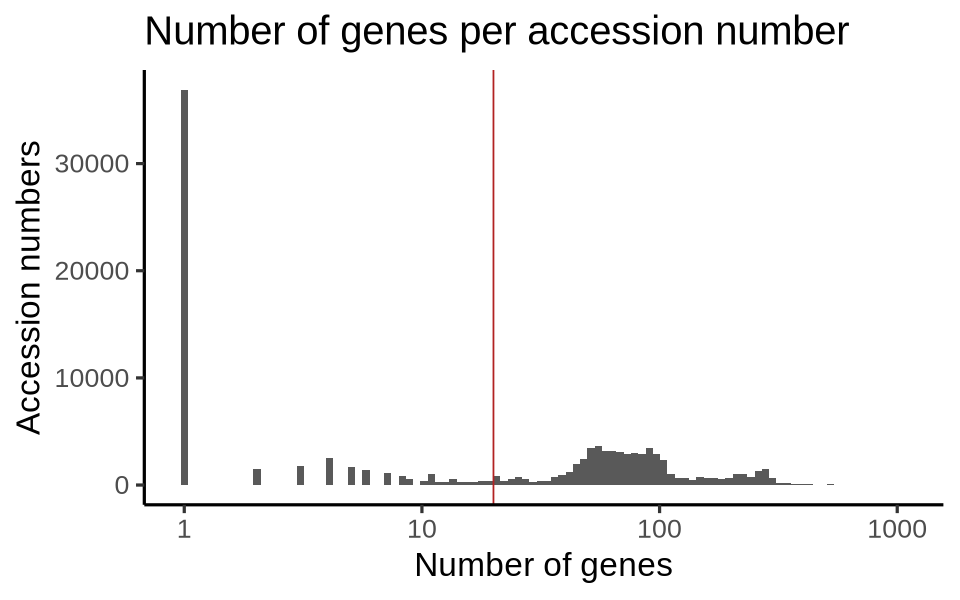

'data.frame':	5769188 obs. of  74 variables:


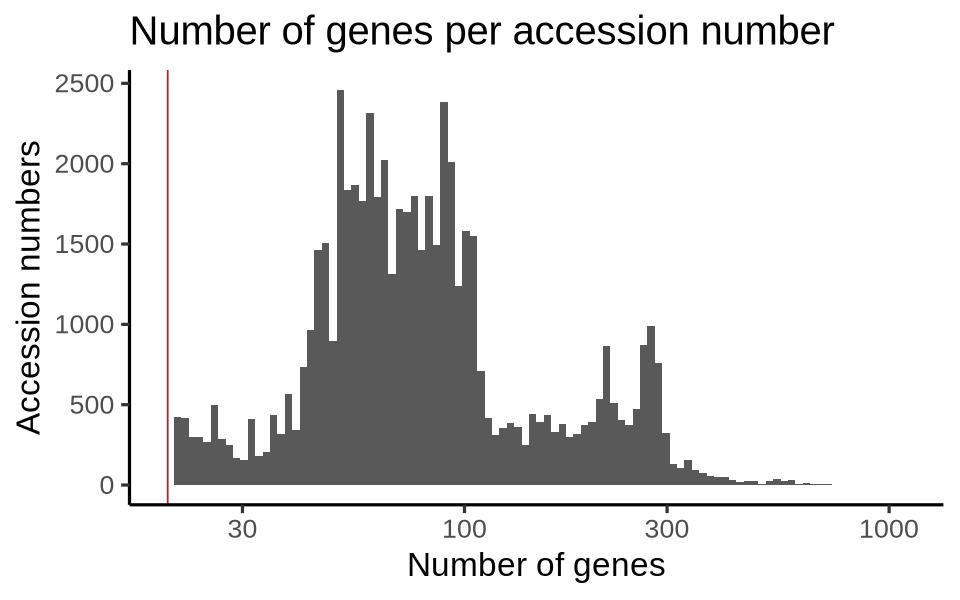

In [25]:
# Filter GTF
options(repr.plot.width=8, repr.plot.height=5)

## Set threshold
thresh <- 20

## Fetch data
df <- features %>% mutate(N = 1) %>% group_by(set, Accession) %>% summarize(total = sum(N))

## Plot
ggplot(df, aes(total)) +
  geom_histogram(bins = 100) + 
  geom_vline(xintercept = thresh, col='firebrick') +
  theme_classic(20) +
  scale_x_continuous(trans='log10') +
  labs(title='Number of genes per accession number', x='Number of genes', y='Accession numbers')

## Filter
index <- df$Accession[df$total > thresh]
index <- features$Accession %in% index
features <- features[index,]

## Fetch data
df <- features %>% mutate(N = 1) %>% group_by(set, Accession) %>% summarize(total = sum(N))

## Plot
ggplot(df, aes(total)) +
  geom_histogram(bins = 100) + 
  geom_vline(xintercept = thresh, col='firebrick') +
  theme_classic(20) +
  scale_x_continuous(trans='log10') +
  labs(title='Number of genes per accession number', x='Number of genes', y='Accession numbers')

## View
str(features, max.level = 0)

In [26]:
## Duplicated genes
features$is_unique <- !duplicated(features$protein_key)
table(features$is_unique, features$set)

       
           test   test2 training validation
  FALSE   62414 2456330      229        353
  TRUE  3218276       0     9412      22174

In [31]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

[1] "Reading table phages"
[1] "Reading table predicted_arabinosylating_phage"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


In [32]:
# Create summary report

## Add dataset info
training$metadata$set <- 'training'
validation$metadata$set <- 'validation'
test$metadata$set <- 'test'
test2$metadata$set <- 'test2'

## Combine
report <- rbind(
    training$metadata,
    validation$metadata,
    test$metadata,
    test2$metadata
)
any(duplicated(report$Accession))

## Extract host genus
report$genus <- case_when(
    report$Host.Name == 'human metagenome' ~ "Metagenome",
    report$Host.Name == 'Homo sapiens' ~ "Metagenome",
    report$Host.Name == 'Bos taurus' ~ "Metagenome",
    report$Host.Name == 'Sus scrofa' ~ "Metagenome",
    str_detect(report$Host.Name, 'Aves') ~ "Metagenome",
    str_detect(report$Host.Name, 'Apis') ~ "Metagenome",
    str_detect(report$Host.Name, 'Bombyx') ~ "Metagenome",
    str_detect(report$Host.Name, '\\[Arthrobacter') ~ "Arthrobacter",
    str_detect(report$Host.Name, '\\[Clostridium') ~ "Clostridium",
    str_detect(report$Host.Name, '\\[Ruminococcus') ~ "Ruminococcus",
    report$Host.Name == '' ~ "Unknown",
    .default = report$Host.Name
)
report$genus <- str_split(report$genus, ' ', simplify=TRUE)[,1]

## View
rbind(head(report,3),tail(report,3))

[1] FALSE

,Accession,BioProjects,BioSample.accession,Completeness,Gene.count,Geographic.Location,Geographic.Region,Geographic.State,Host.Common.Name,Host.Infraspecific.Names.Breed,⋯,Virus.Infraspecific.Names.Cultivar,Virus.Infraspecific.Names.Ecotype,Virus.Infraspecific.Names.Isolate,Virus.Infraspecific.Names.Sex,Virus.Infraspecific.Names.Strain,Virus.Name,Virus.Pangolin.Classification,Virus.Taxonomic.ID,set,genus
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<int>,<chr>,<chr>
1,AF158101.6,,,COMPLETE,278,,,,NA,NA,⋯,NA,NA,NA,NA,NA,Escherichia phage T4,NA,2681598,training,Escherichia
2,MK639187.1,,,COMPLETE,266,China,Asia,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage SSE1,NA,2562131,training,Shigella
3,MK962754.1,,,COMPLETE,280,Ireland,Europe,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage JK36,NA,2591060,training,Escherichia
66819,BK056824.1,"PRJEB6997,PRJNA573942",SAMEA2737722,PARTIAL,22,USA,North America,,NA,NA,⋯,NA,NA,NA,NA,NA,Bacteriophage sp.,NA,38018,test2,Metagenome
66820,BK056880.1,"PRJNA48479,PRJNA573942",SAMN00038409,PARTIAL,26,USA,North America,,NA,NA,⋯,NA,NA,NA,NA,NA,Bacteriophage sp.,NA,38018,test2,Metagenome
66821,BK056923.1,"PRJEB6997,PRJNA573942",SAMEA2737799,PARTIAL,103,USA,North America,,NA,NA,⋯,NA,NA,NA,NA,NA,Bacteriophage sp.,NA,38018,test2,Metagenome


`summarise()` has grouped output by 'set', 'genus'. You can override using the
`.groups` argument.


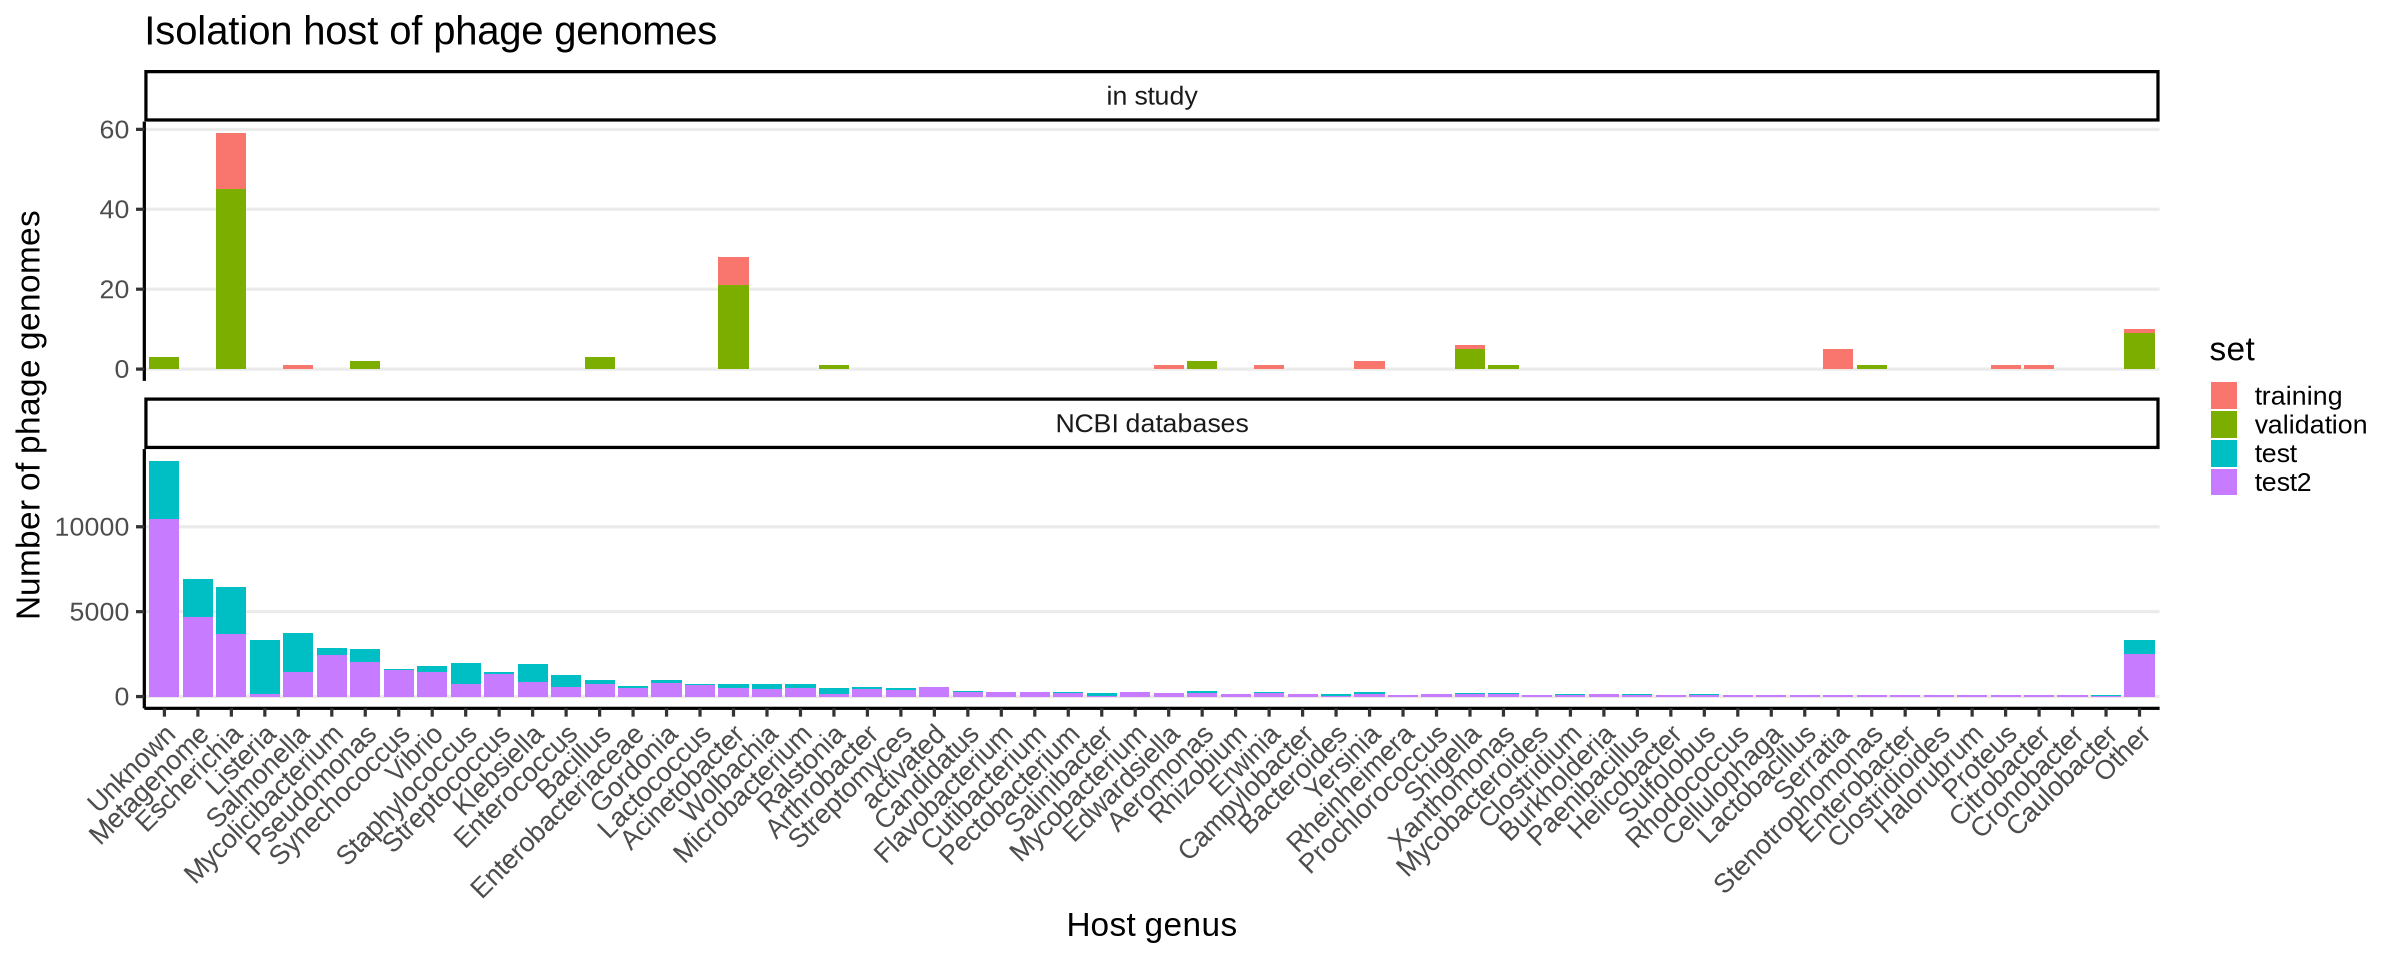

In [33]:
# Representativeness of data sets
options(repr.plot.width=20, repr.plot.height=8)

## Select
df <- report
df$N <- 1

## Summarize
df <- df %>% group_by(genus) %>% mutate(genus_size = sum(N))
df$genus[df$genus_size < 70] <- 'Other' # 70
df <- df %>% group_by(set, genus, Source.database) %>% summarize(total = sum(N))

## Order
df <- df[order(df$total, decreasing = TRUE), ]
genus_levels <- unique(df$genus)
genus_levels <- genus_levels[-which(genus_levels == 'Other')]
genus_levels <- c(genus_levels, 'Other')
df$genus <- factor(df$genus, genus_levels)
df$set <- factor(df$set, c('training','validation','test','test2'))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training','validation')] <- 'in study'
df$facet[df$set %in% c('test','test2')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus, total, fill=set)) +
  geom_col() +
  facet_wrap(~facet, nrow = 2, scales = 'free_y') +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  labs(title='Isolation host of phage genomes', x = 'Host genus', y='Number of phage genomes')

In [34]:
# Check for duplicated accession numbers
report$is_unique <- !duplicated(report$Accession)
table(report$is_unique, report$set)

      
        test test2 training validation
  TRUE 22467 44226       35         93

In [41]:
# Annotation

## Fetch data
data <- features[features$set == 'training',]
length(unique(data$Gene.CDS.Name))

## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')]

# Transfer into new vector
data$annotation <- data$Gene.CDS.Name
data$annotation <- 'Other'

## Step A - dCTP modification
data$annotation[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$annotation[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'HMase'
data$annotation[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'HMase'
data$annotation[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'
data$annotation[str_detect(data$Gene.CDS.Name, 'DNA pol')] <- 'DNA pol'

## Step B - UTP arabinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Aat'
# Most Aat genes are not annotated !!!

## Step E - function?
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

unique(data$annotation)
length(unique(data$annotation))

[1] 1086

[1] "putative hmC-arabinosyltransferase" "putative hmC-arabinosyltransferase"

[1] "Other"        "dCTPase"      "Glu transfer" "HMase"        "DNA pol"     
 [6] "dNMP kinase"  "Thy syn"      "Ara iso"      "Thy kin"      "Aat"         
[11] "NTP transfer"

[1] 11

In [43]:
# Modify data

## Modification group
index <- match(data$Accession, tables$phages$accession)
data$aat <- tables$phages$group_aat[index]
data$modification <- tables$phages$group_modification[index]

## Genome size
data <- data %>% group_by(Accession) %>% mutate(
    genomeSize = max(Gene.CDS.Nucleotide.FASTA.Range.Stop, na.rm=TRUE) - min(Gene.CDS.Nucleotide.FASTA.Range.Start, na.rm=TRUE)
)

## Add virus name
index <- match(data$Accession, report$Accession)
data$Name <- report$Virus.Name[index]

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


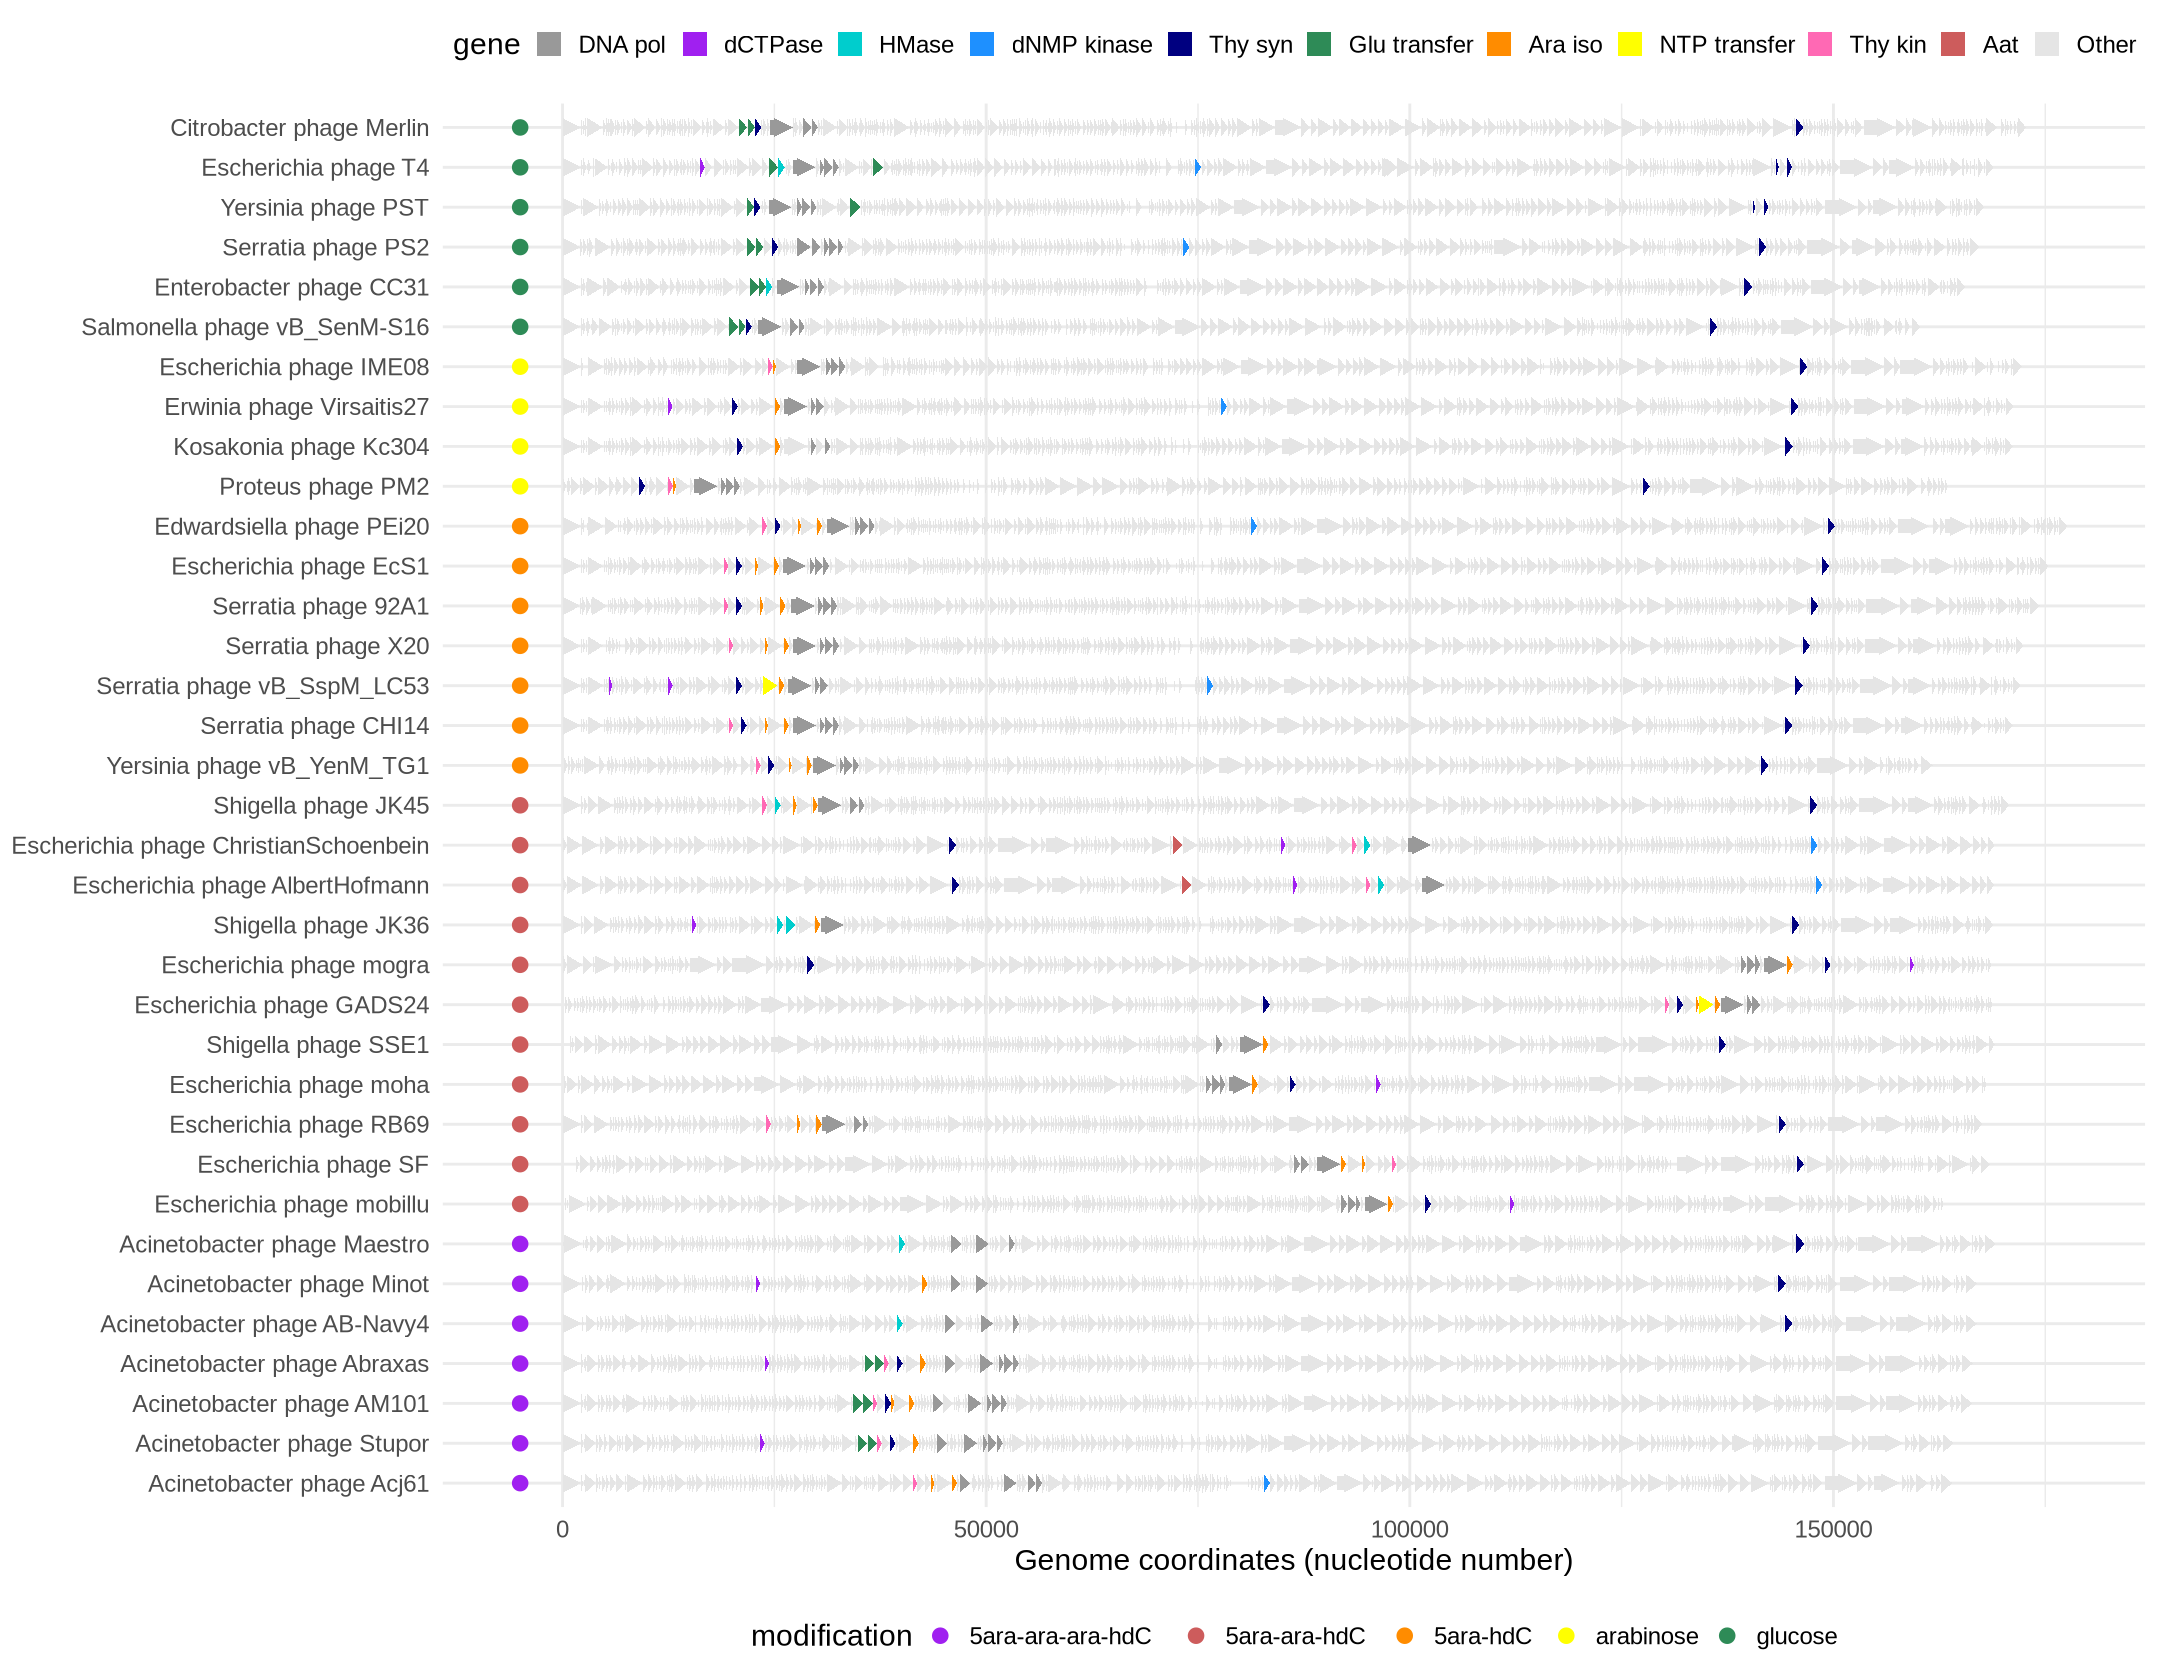

In [44]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=1), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

[1] "Aat"          "Ara iso"      "dCTPase"      "HMase"        "dNMP kinase" 
[6] "NTP transfer" "Thy kin"      "Thy syn"      "Glu transfer"

[1] TRUE

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


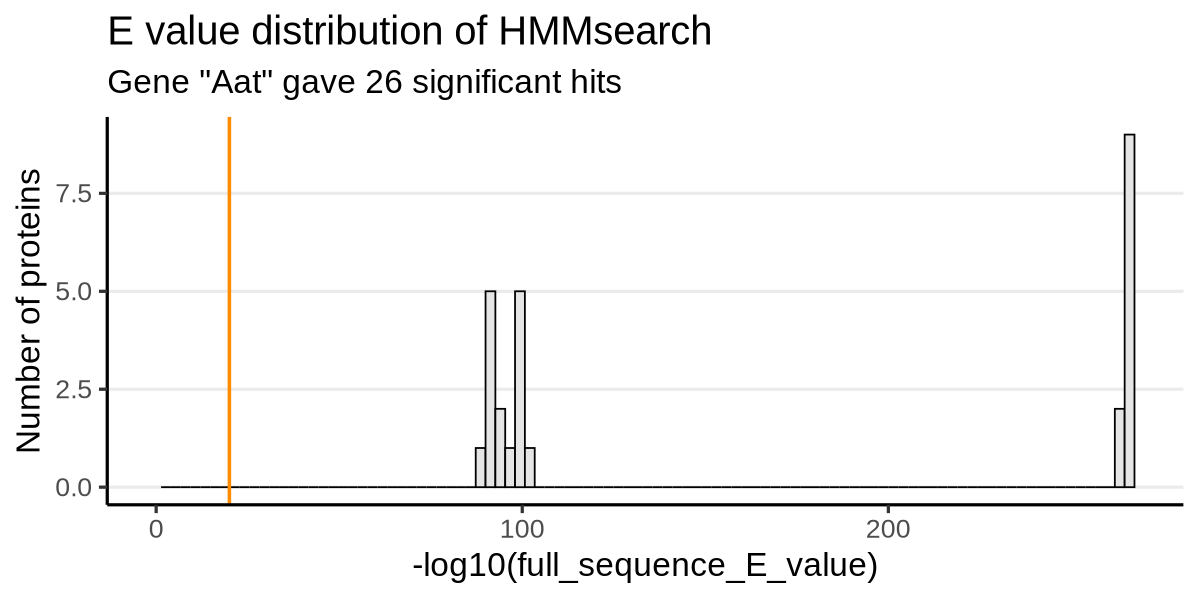

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


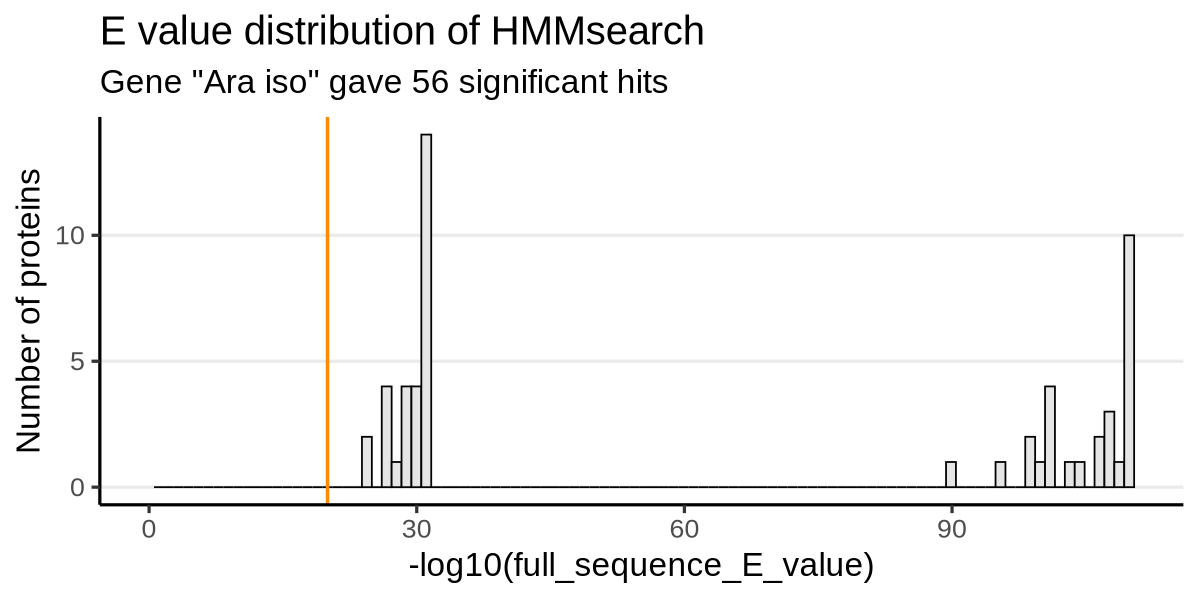

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 90”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 

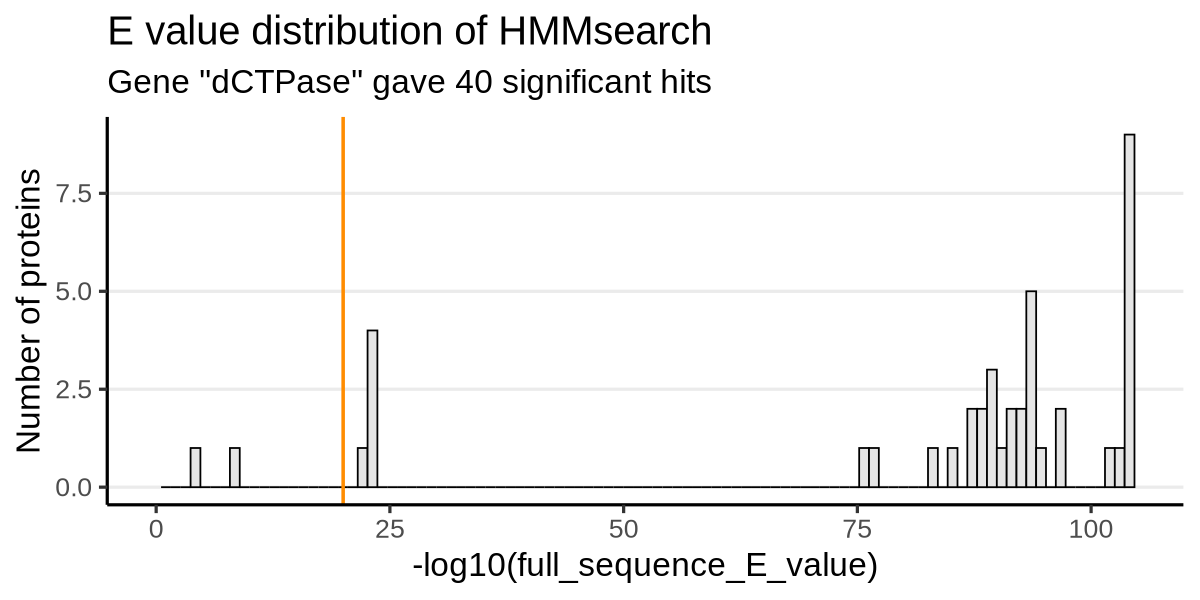

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


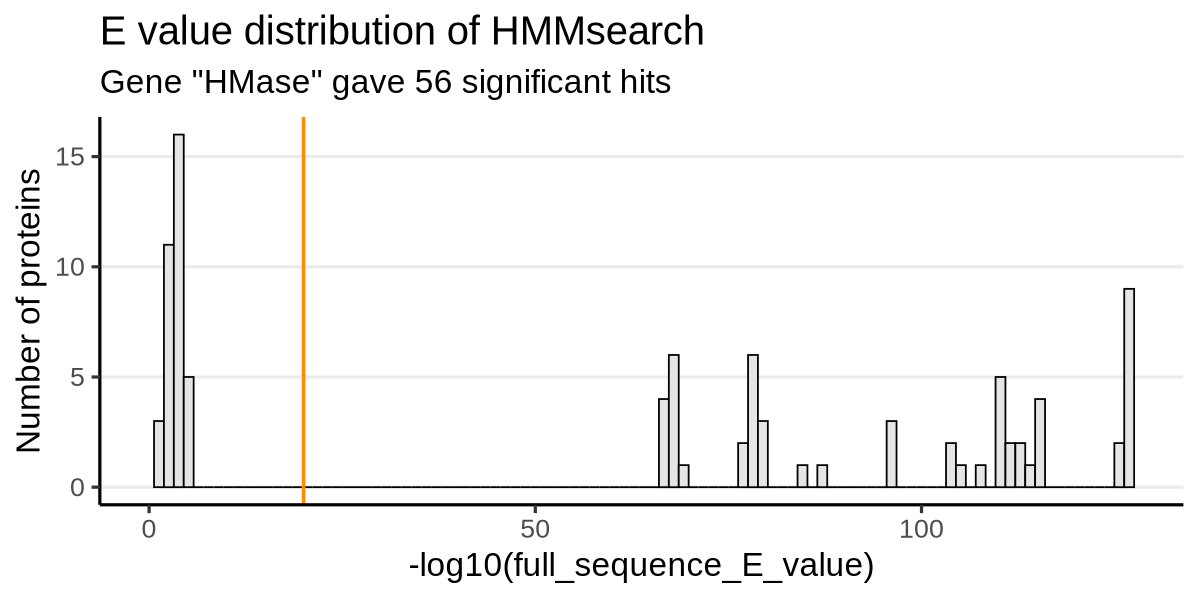

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 16 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


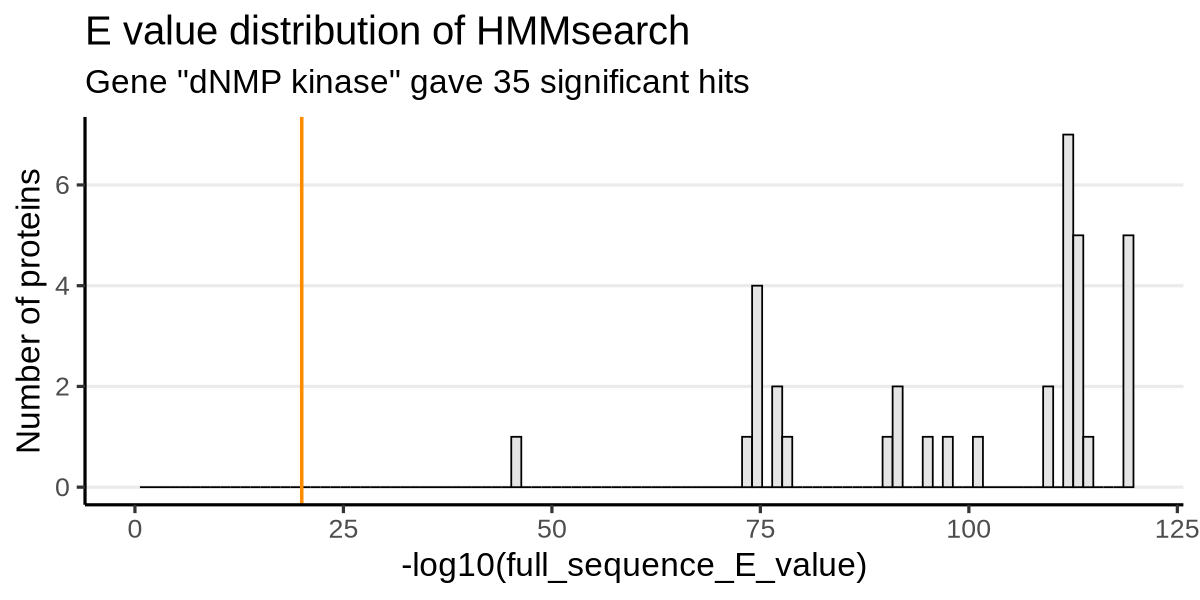

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


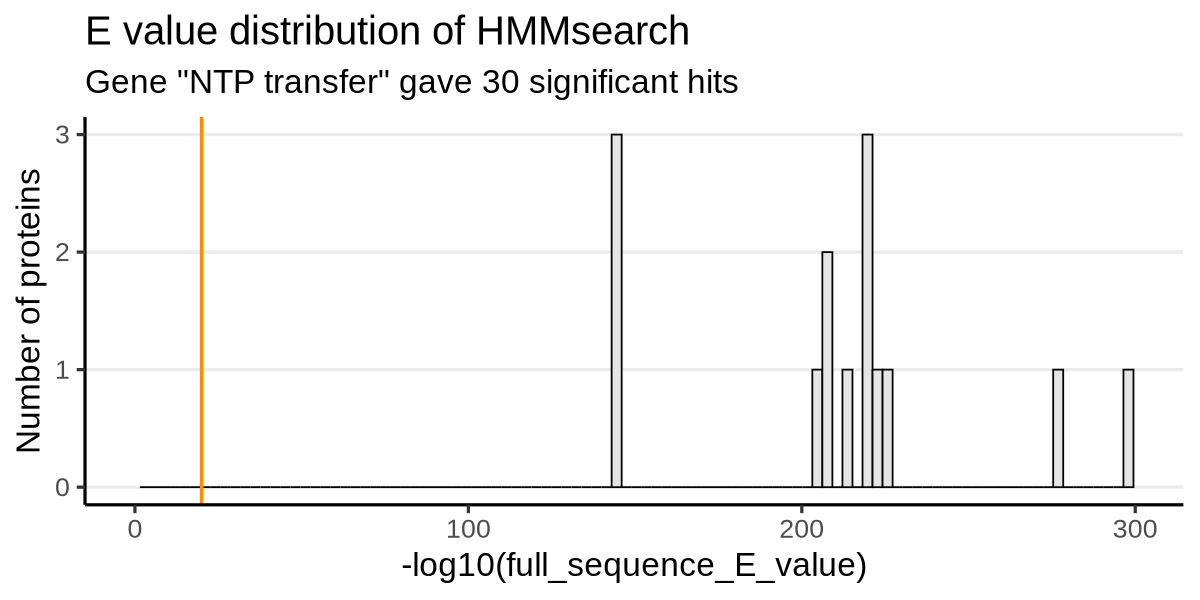

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


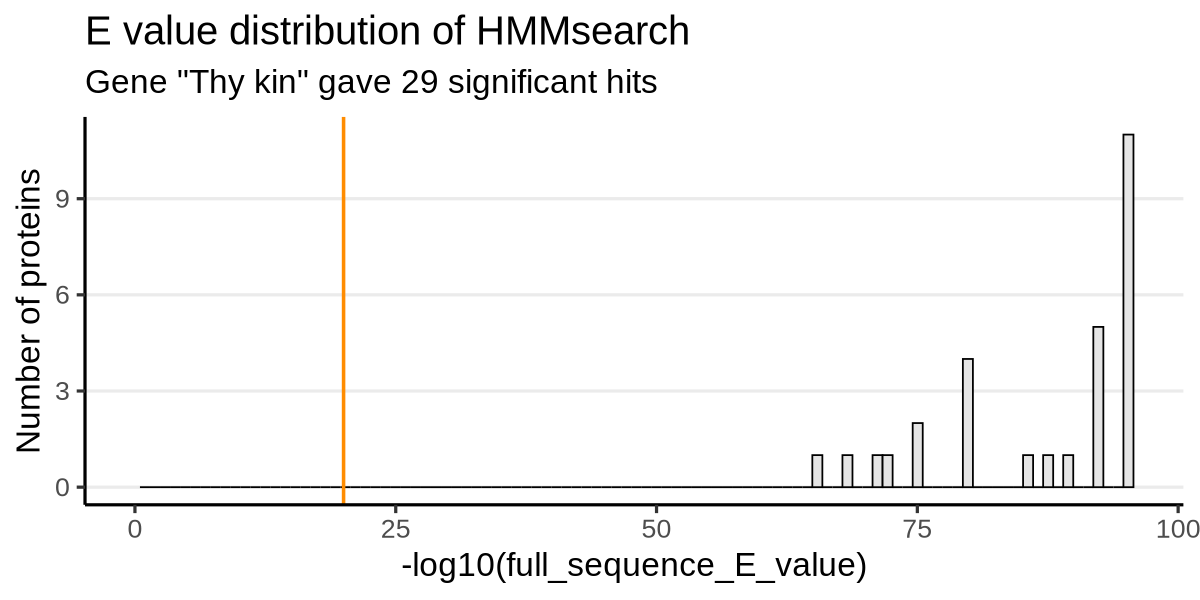

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


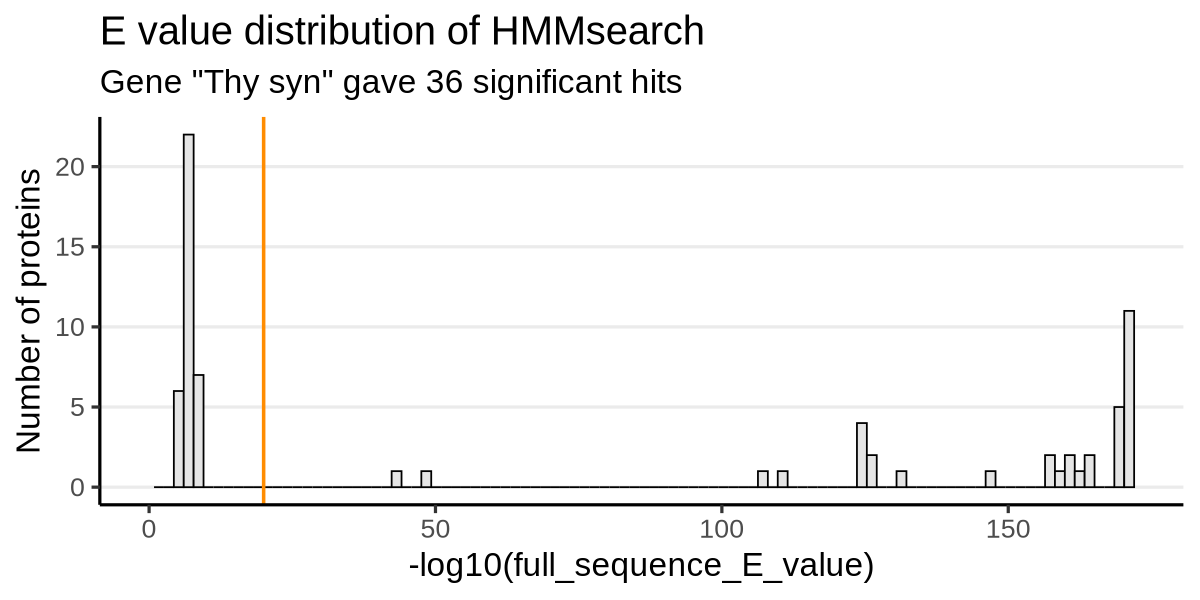

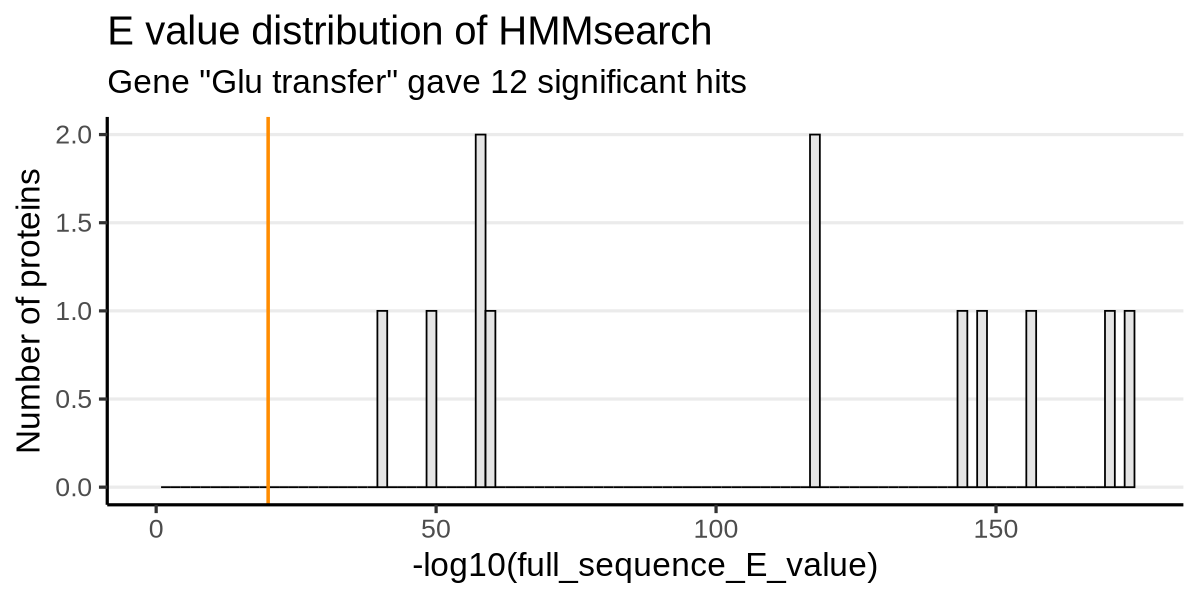

In [45]:
# Refine annotations
options(repr.plot.width=10, repr.plot.height=5)

genes <- c('Aat','Ara iso','dCTPase','HMase','dNMP kinase','NTP transfer','Thy kin','Thy syn','Glu transfer')
genes

## Check spelling
all(genes %in% levels(data$annotation))

## Iterate annotation over genes
for (gene in genes) {
    x <- annotate_gene_by_hmm_profile(data, gene = gene, search_db = fs$training$protein, dir = out_path)$Sequence
    data$annotation[which(data$Gene.CDS.Protein.FASTA.Sequence.ID %in% x)] <- gene
}

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


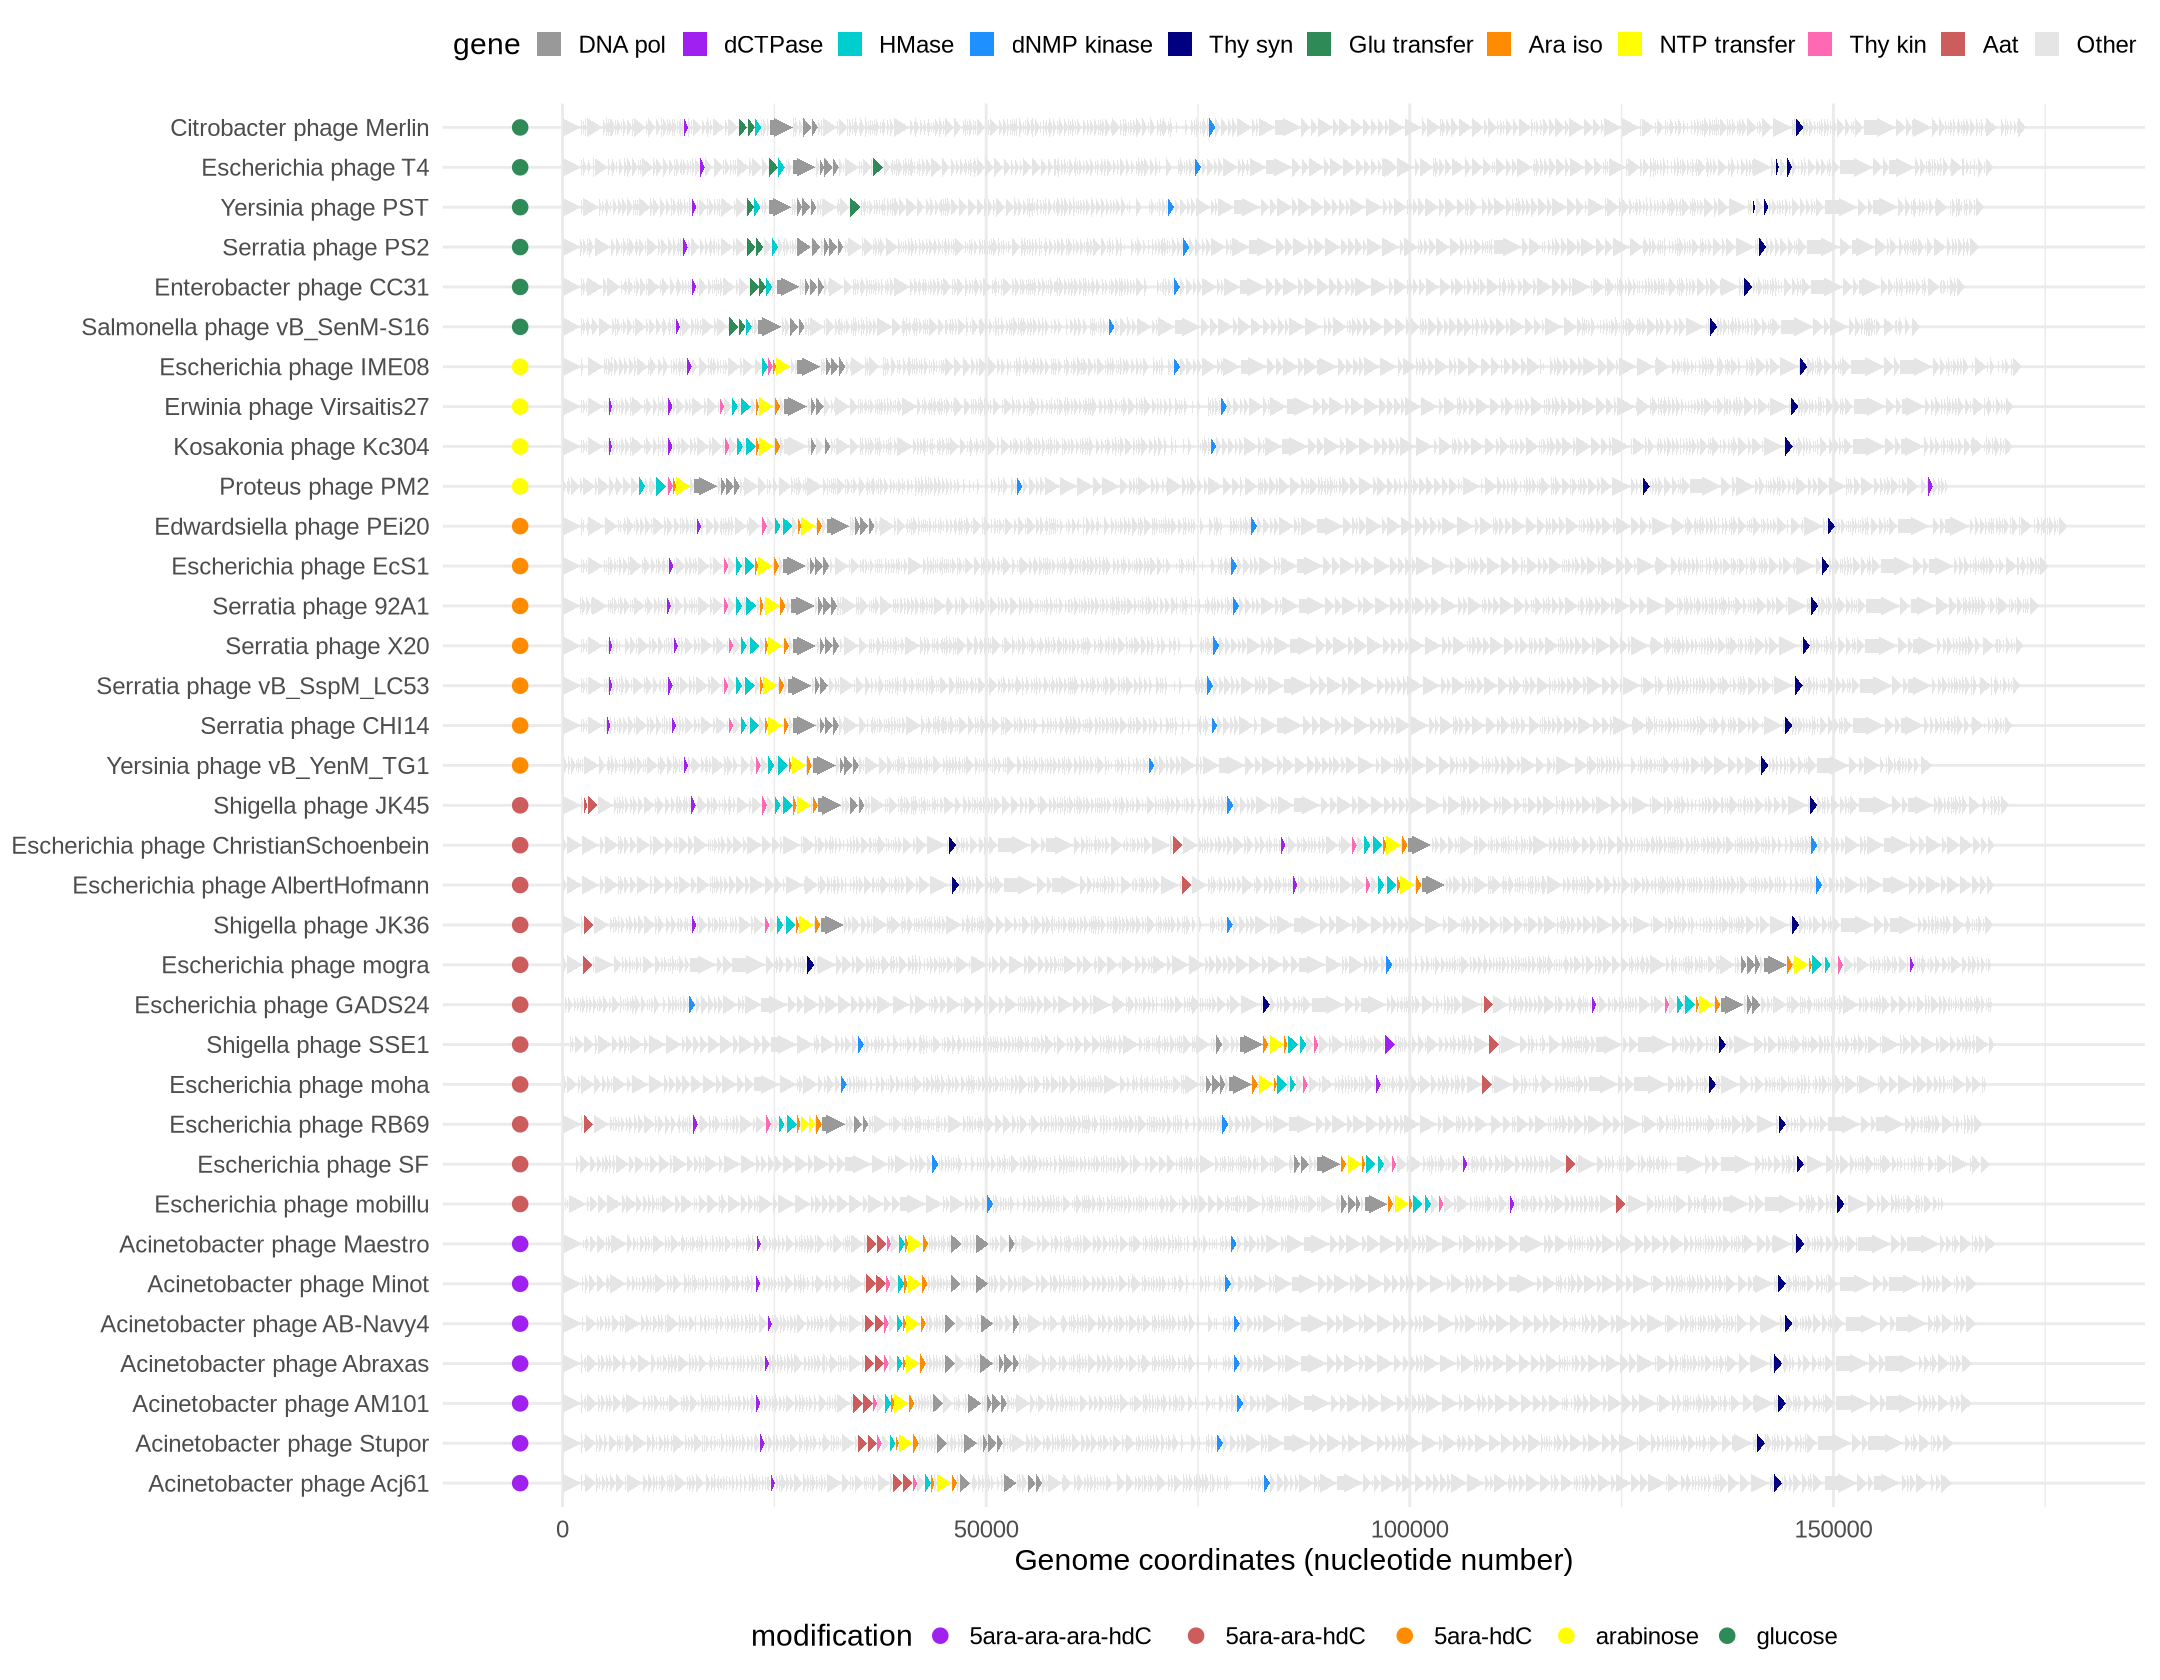

In [46]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=1), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

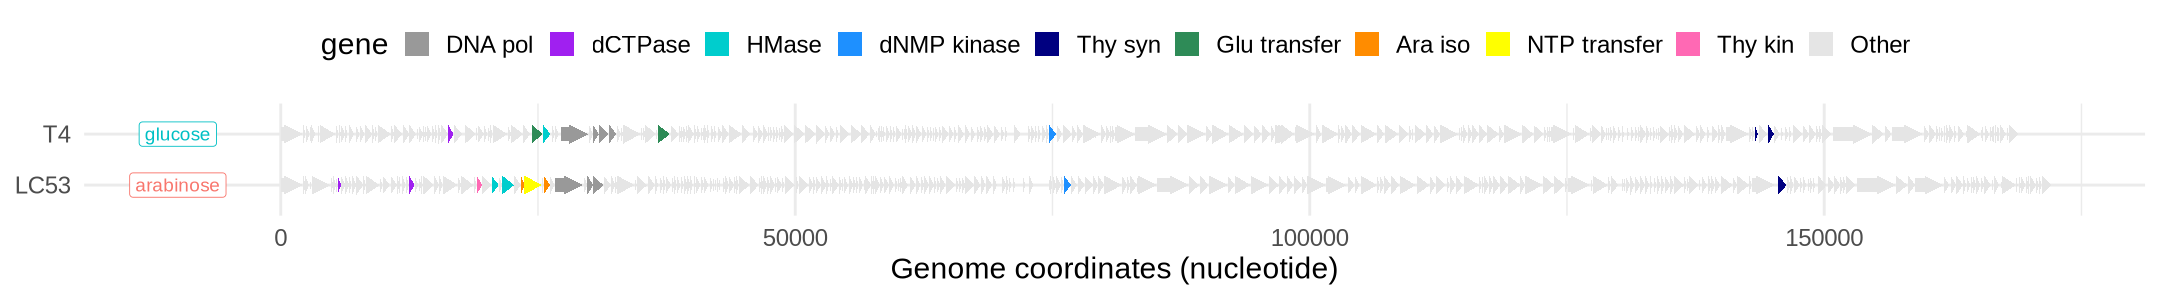

In [47]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=2.5)

## Fetch data
df <- data %>% subset(Name %in% c('Escherichia phage T4','Serratia phage vB_SspM_LC53'))

## Change name
df$short_name <- NA
df$short_name[df$Name == 'Escherichia phage T4'] <- 'T4'
df$short_name[df$Name == 'Serratia phage vB_SspM_LC53'] <- 'LC53'

## Create annotations
ann <- df %>% select(Accession, modification, aat, short_name) %>% unique()
ann$modification[[2]] <- 'arabinose'

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Accession <- factor(df$Accession, unique(df$Accession))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=1), 
           col = guide_none()) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

Warning message:
“Removed 461 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 543 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 539 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”


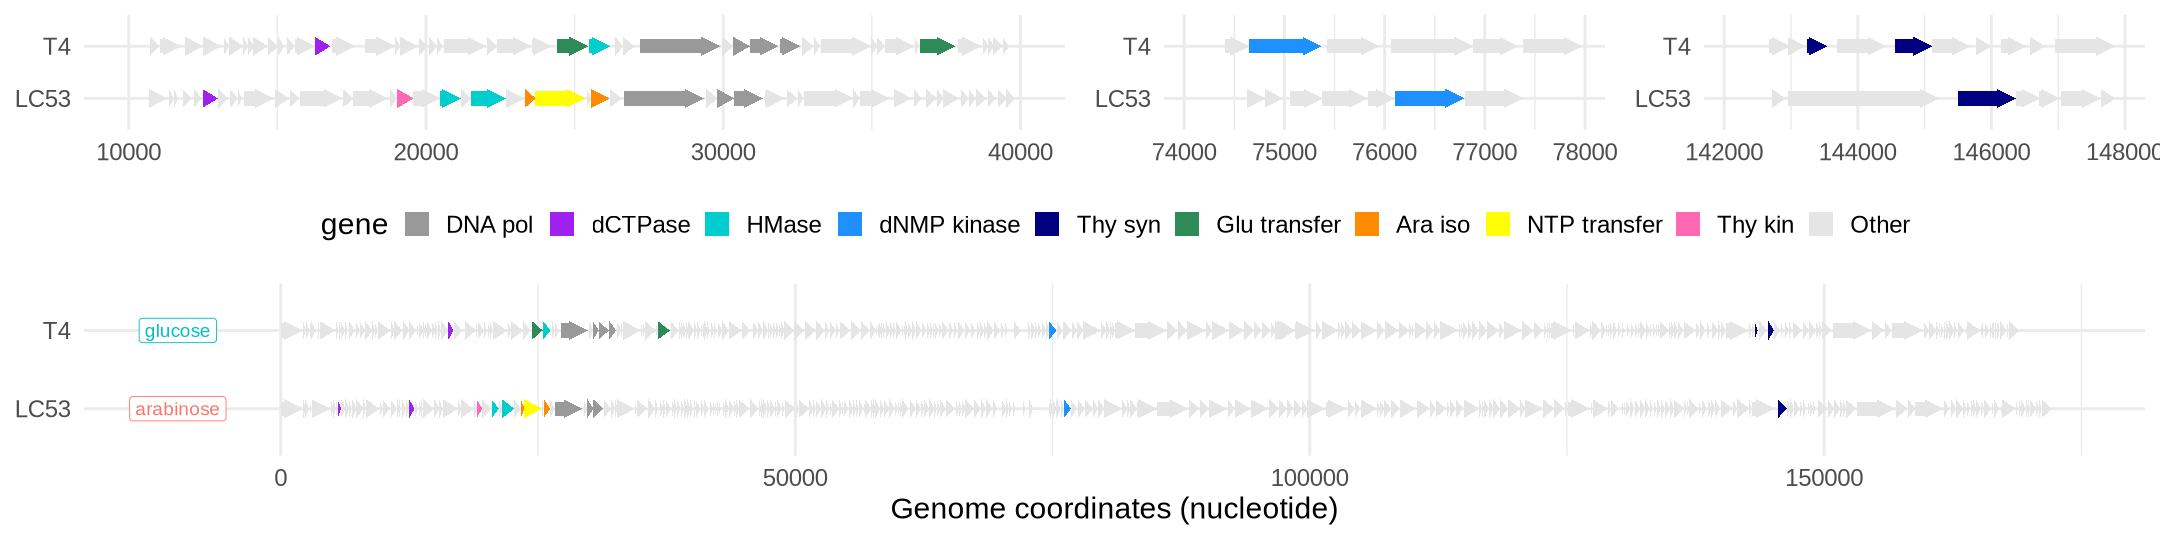

In [48]:
# Focus on genomic regions
options(repr.plot.width=18, repr.plot.height=4.5)

## Plot
p2 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(10000, 40000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Plot
p3 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(74000, 78000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Plot
p4 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(142000, 148000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Layout
grid <- cowplot::plot_grid(p2,p3,p4, nrow = 1, rel_widths = c(2,1,1))
grid <- cowplot::plot_grid(grid, p1, nrow=2, rel_heights = c(1,2))
grid

## Save
fn <- paste0(out_path,'figure_1E','.png')
ggsave(fn, grid, width = 18, height = 4.5, device = 'png')

fn <- paste0(out_path,'figure_1E','.pdf')
ggsave(fn, grid, width = 18, height = 4.5)

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 104 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


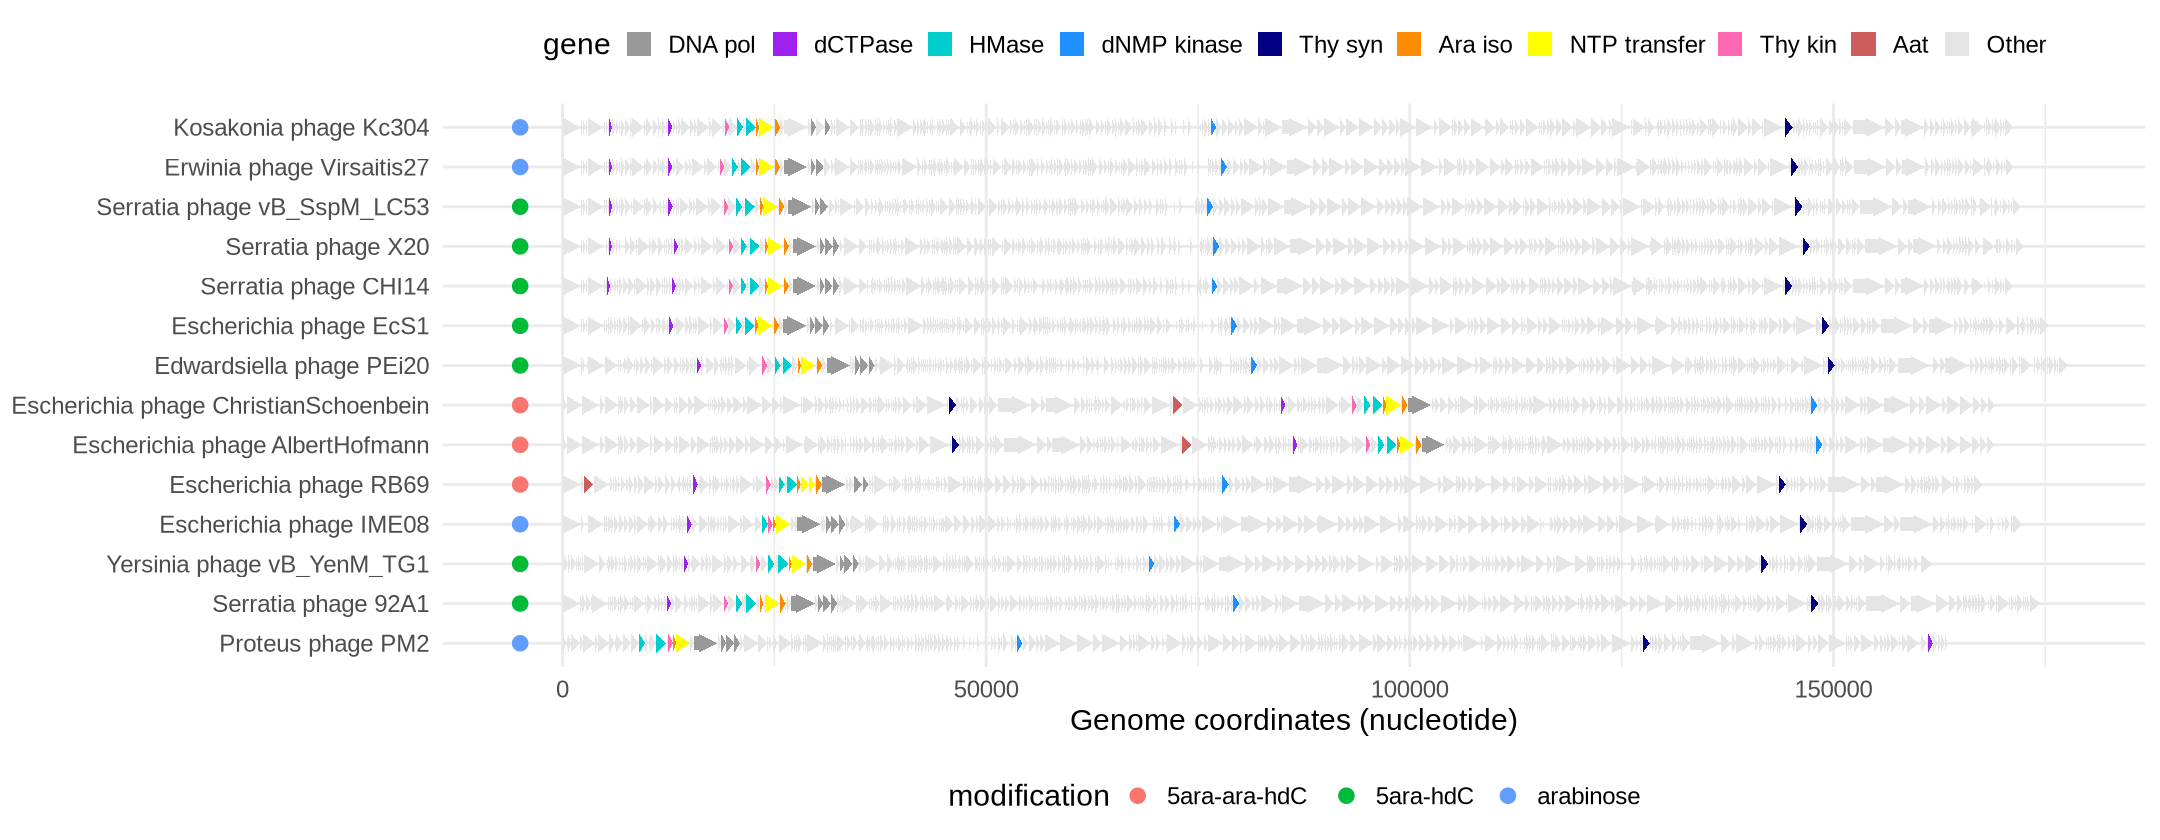

In [49]:
# Visualize genomes with different arabinosylation states
options(repr.plot.width=18, repr.plot.height=7)

## Fetch data
index <- unique(data$Name)[c(11,32,33,29,24,27,21,13,12,14,15,22,35,28)]
df <- data %>% subset(Name %in% index)

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Name <- factor(df$Name, rev(index))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=1), 
           col = guide_legend(position = 'bottom', nrow=1)) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

In [50]:
tmp <- data.frame(N=1:length(unique(data$Name)), name=unique(data$Name))
tmp[which(str_detect(tmp$name, 'Maestro')), ]
index <- c(14,13,33,35,31,9)
unique(data$Name)[index]

,N,name
,<int>,<chr>
9,9,Acinetobacter phage Maestro


[1] "Escherichia phage RB69"               
[2] "Escherichia phage ChristianSchoenbein"
[3] "Serratia phage vB_SspM_LC53"          
[4] "Serratia phage 92A1"                  
[5] "Acinetobacter phage AB-Navy4"         
[6] "Acinetobacter phage Maestro"

Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


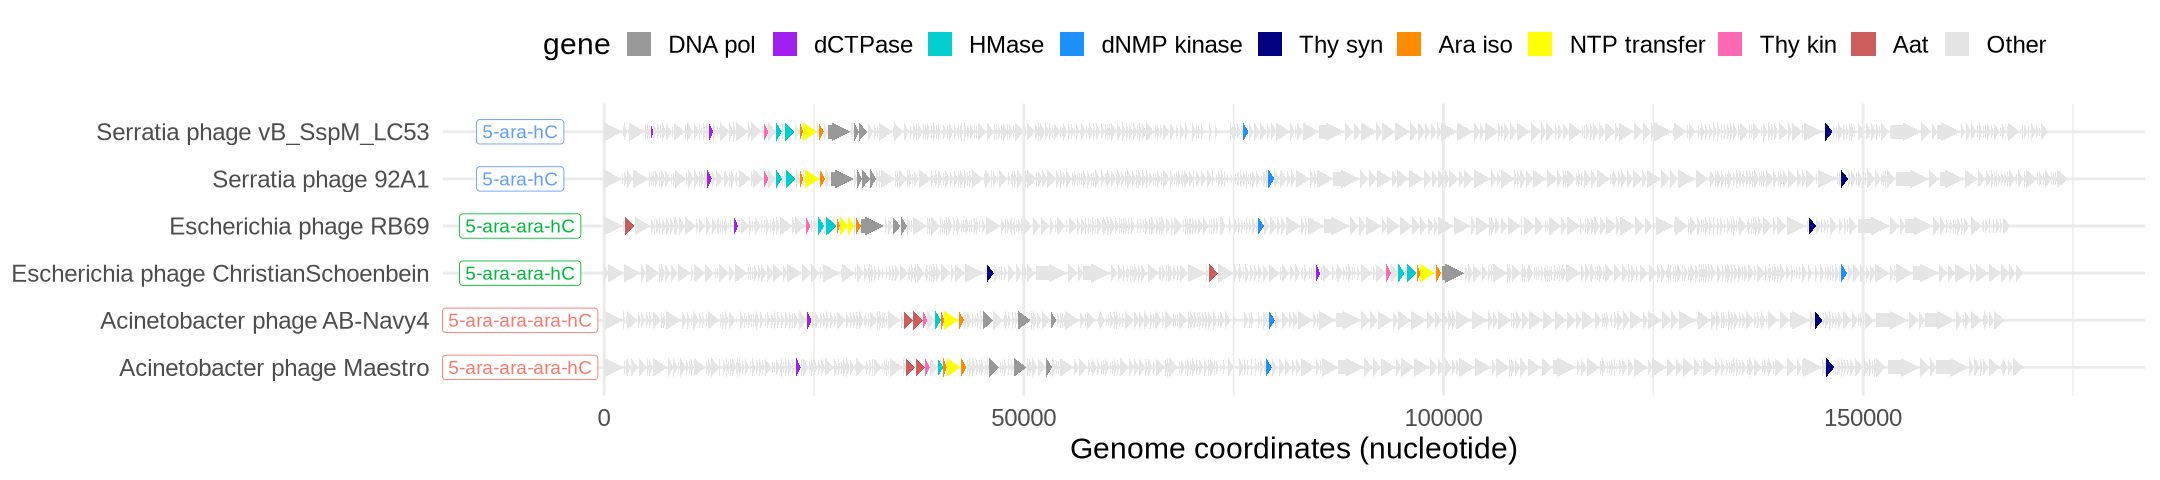

In [51]:
# Visualize genomes with different arabinosylation states
options(repr.plot.width=18, repr.plot.height=4)

## Fetch data
index <- unique(data$Name)[c(33,35,14,13,31,9)]
df <- data %>% subset(Name %in% index)

## Update modification
df$modification[df$Name %in% c('Serratia phage vB_SspM_LC53','Serratia phage 92A1')] <- '5-ara-hC'
df$modification[df$Name %in% c('Escherichia phage RB69','Escherichia phage ChristianSchoenbein')] <- '5-ara-ara-hC'
df$modification[df$Name %in% c('Acinetobacter phage AB-Navy4','Acinetobacter phage Maestro')] <- '5-ara-ara-ara-hC'
## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Name <- factor(df$Name, rev(index))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_label(data=ann, aes(x=-10000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=1), 
           col = guide_none()) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.



Arabinosylation   Glucosylation 
             29               6 

< table of extent 0 >

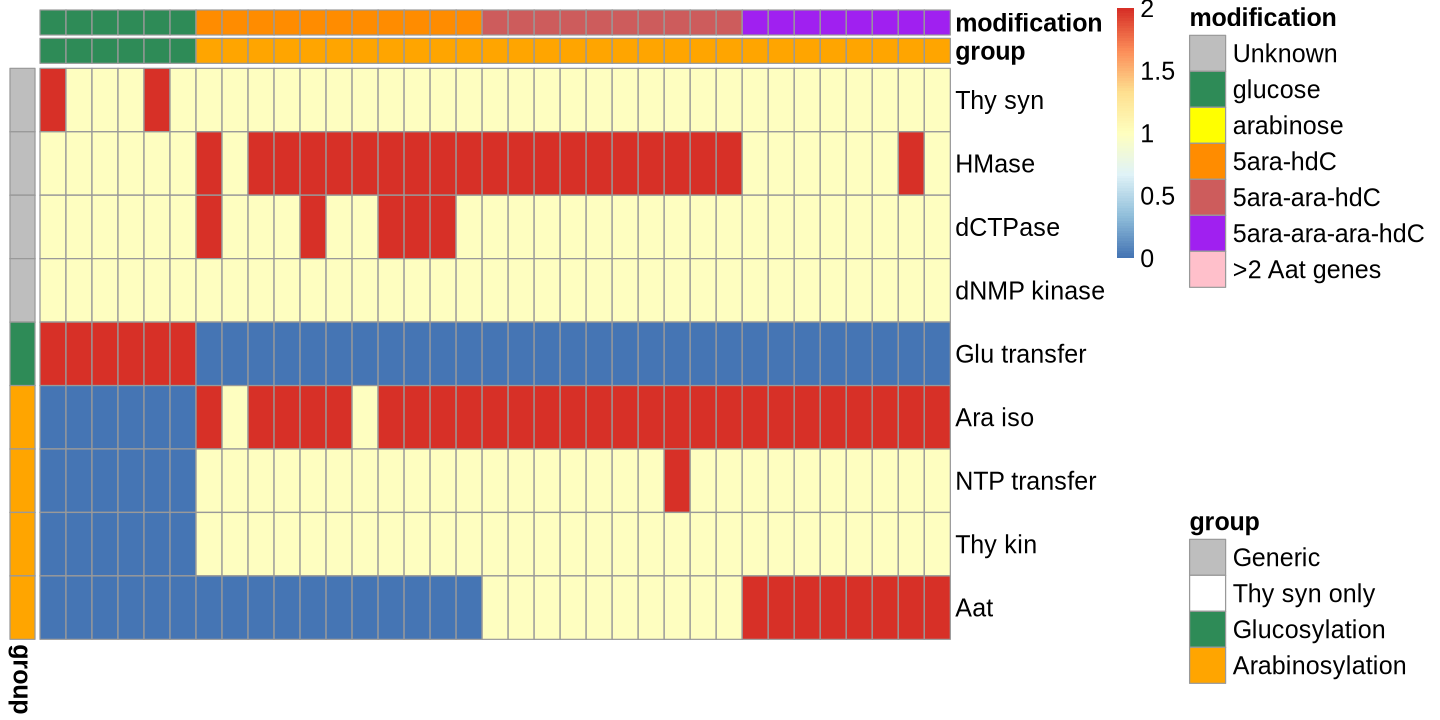

In [278]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=6)

heatmap_genes <- c('Thy syn','HMase','dCTPase','dNMP kinase','Glu transfer','Ara iso','NTP transfer','Thy kin','Aat')

## Summarize gene counts
df <- data %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

### Row
rann <- data.frame(
    row.names = rownames(mat),
    group = c('Generic','Generic','Generic','Generic','Glucosylation',
              'Arabinosylation','Arabinosylation','Arabinosylation','Arabinosylation')
)
rann$group <- factor(rann$group, unique(rann$group))

### Col
cann <- data.frame(
    row.names = colnames(mat)
)

##  Cluster

### Level 1
cann$group <- 'Thy syn only'
cann$group[mat['HMase',] > 0 | mat['dCTPase',] > 0 | mat['dNMP kinase',] > 0] <- 'Generic'
cann$group[cann$group == 'Generic' & mat['Glu transfer',] > 0] <- 'Glucosylation'
cann$group[cann$group == 'Generic' & mat['Ara iso',] > 0 | mat['NTP transfer',] > 0 | mat['Thy kin',] > 0] <- 'Arabinosylation'

### Level 2
cann$modification <- 'none'
cann$modification[cann$group == 'Glucosylation'] <- 'glucose'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==0] <- '5ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==1] <- '5ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==2] <- '5ara-ara-ara-hdC'

## Order
mat <- mat[,order(cann$group, cann$modification, decreasing = c(TRUE, TRUE), method = 'radix')]

## Plot
p1 <- pheatmap::pheatmap(mat, 
                         cluster_rows = FALSE, cluster_cols=FALSE,
                         show_colnames=FALSE, annotation_colors=cols,
                         annotation_row = rann, annotation_col = cann,
                         fontsize = 15
                        )

## Quantify
table(cann$group)
table(cann$arabinosylation)

[1] "Aat"          "Ara iso"      "dCTPase"      "HMase"        "dNMP kinase" 
[6] "NTP transfer" "Thy kin"      "Thy syn"      "Glu transfer"

[1] TRUE

character(0)

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 277”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 135 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remove

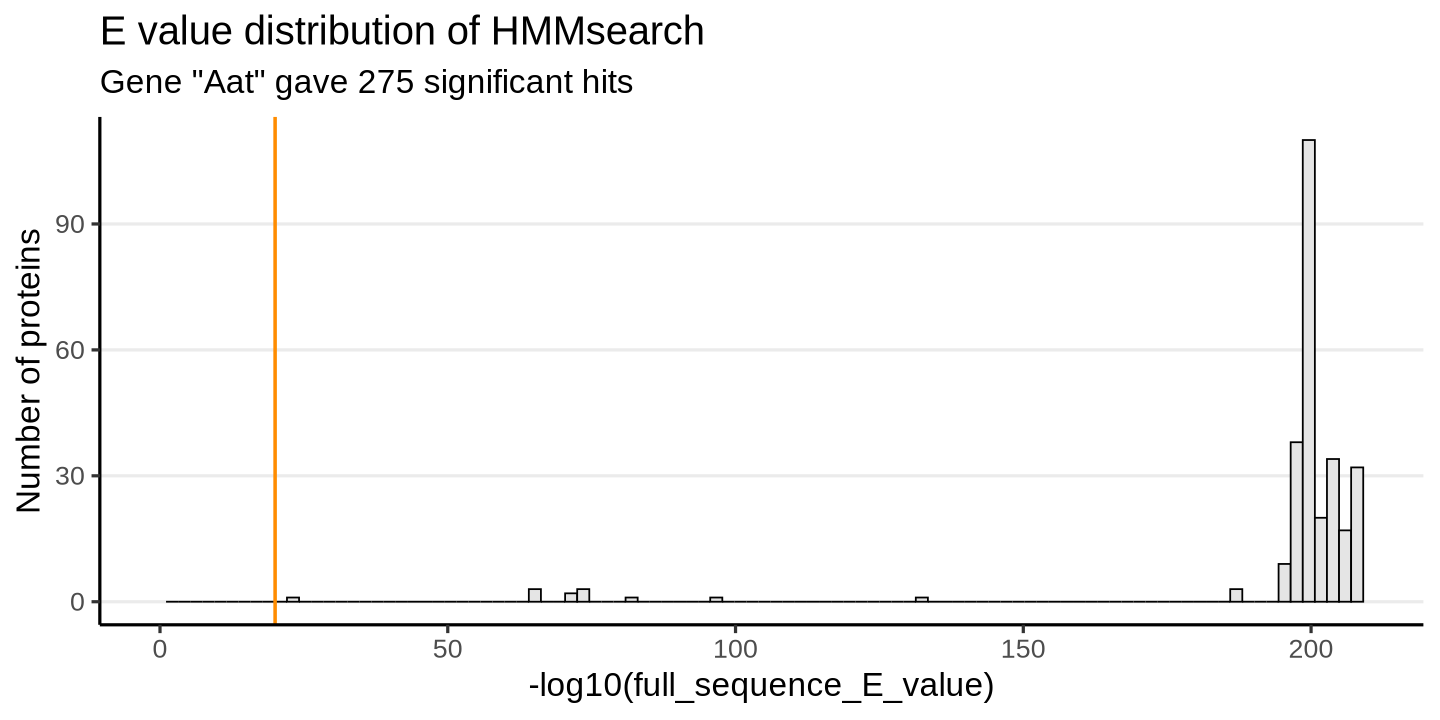

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 2159”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 329 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

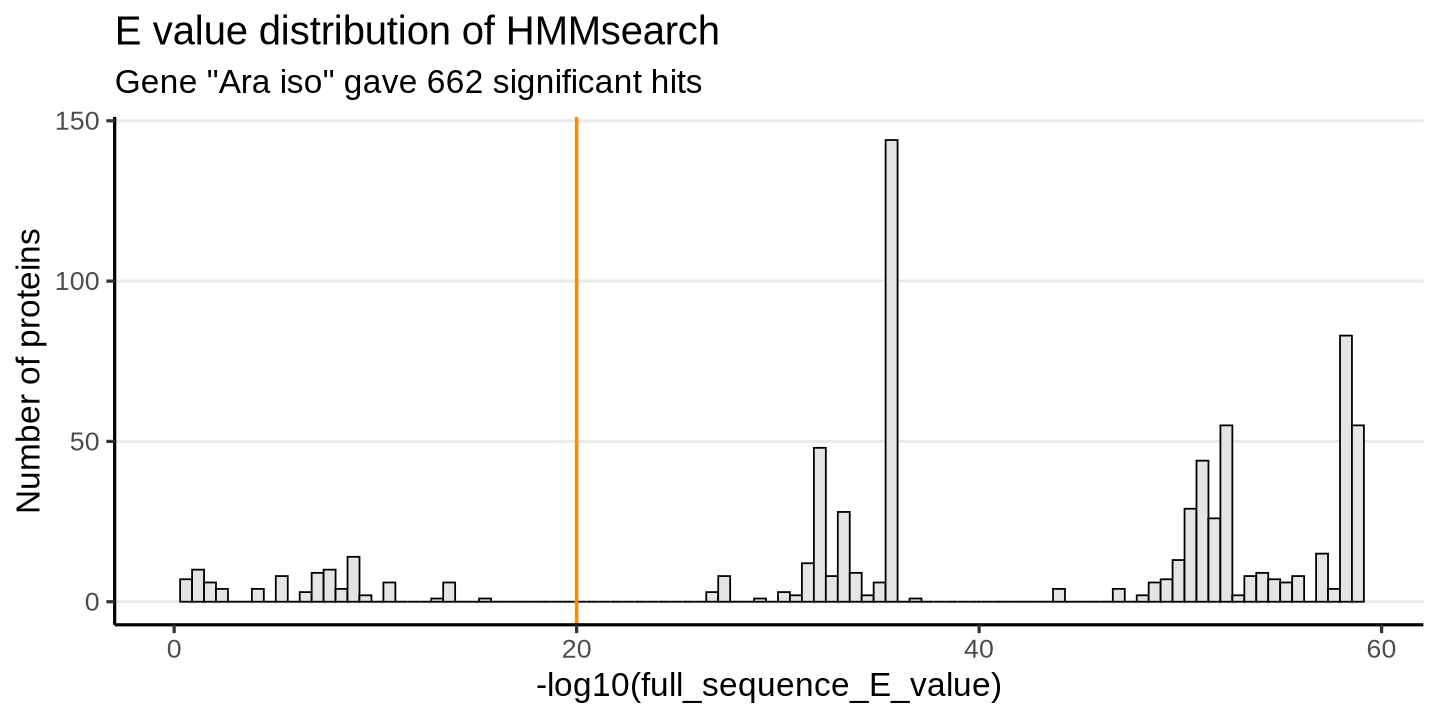

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 5440”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 587 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

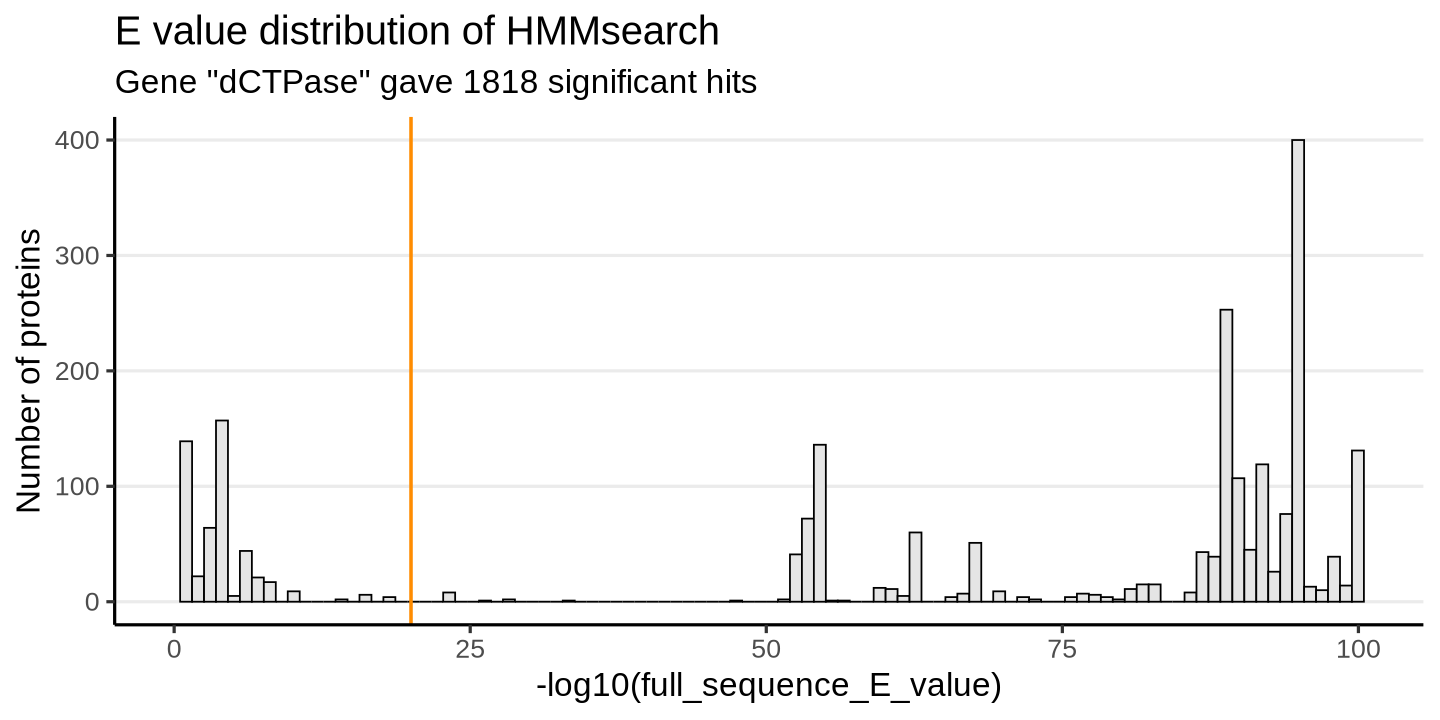

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 6392”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 399 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

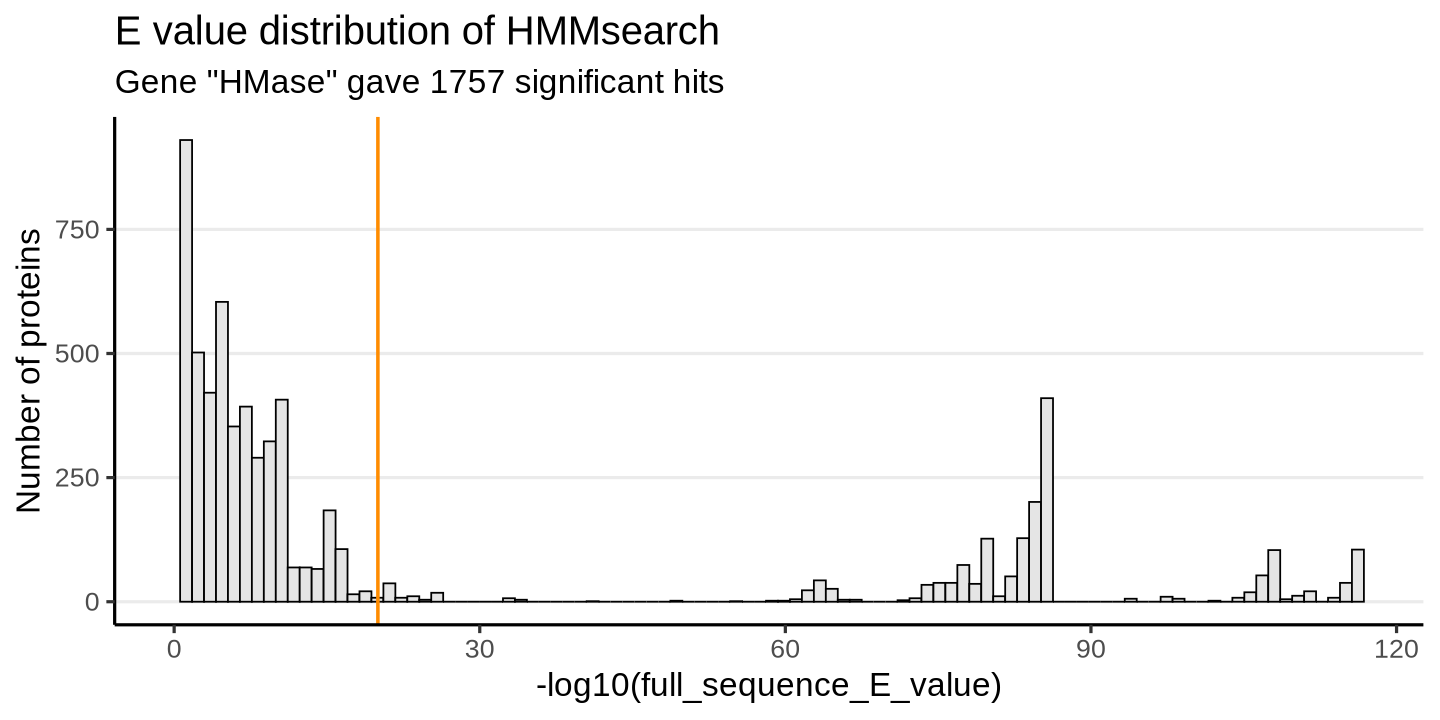

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 442”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 151 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remove

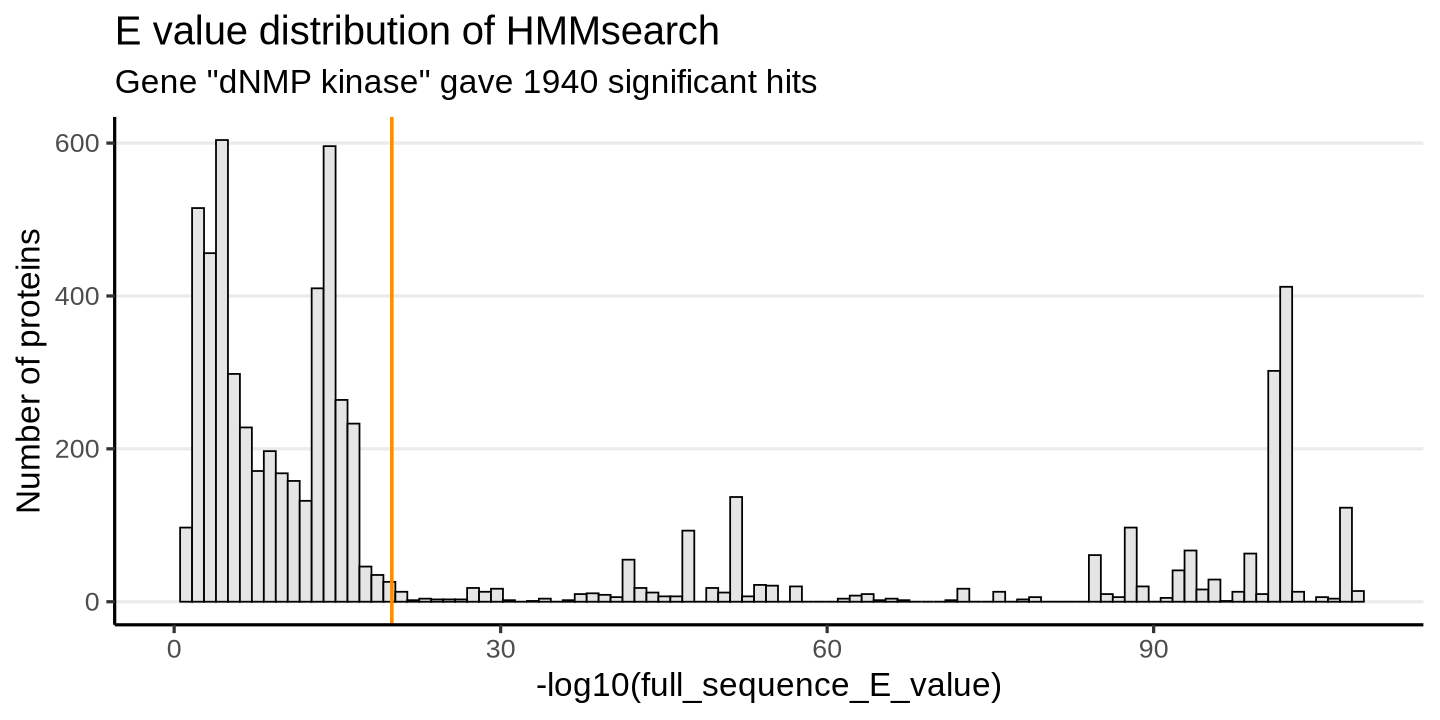

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 716”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 299 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remove

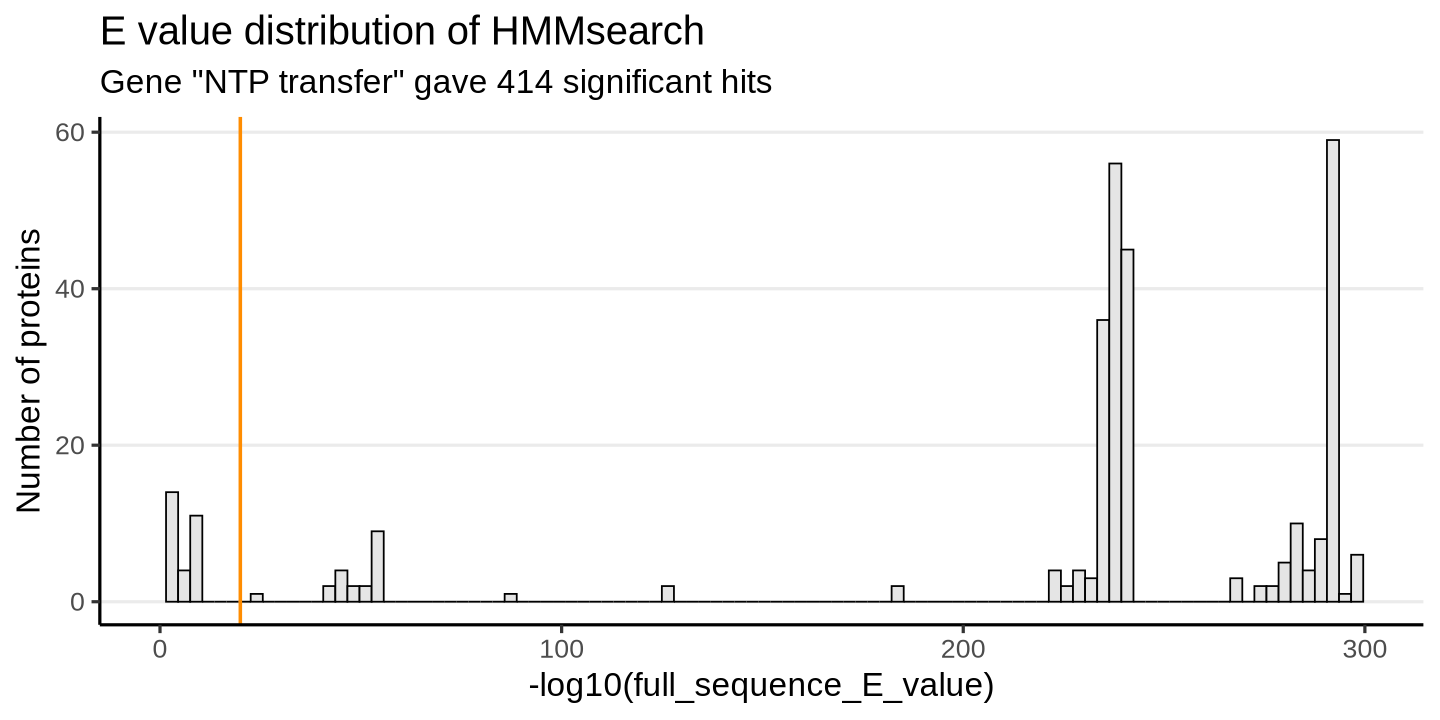

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 9045”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 76 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remove

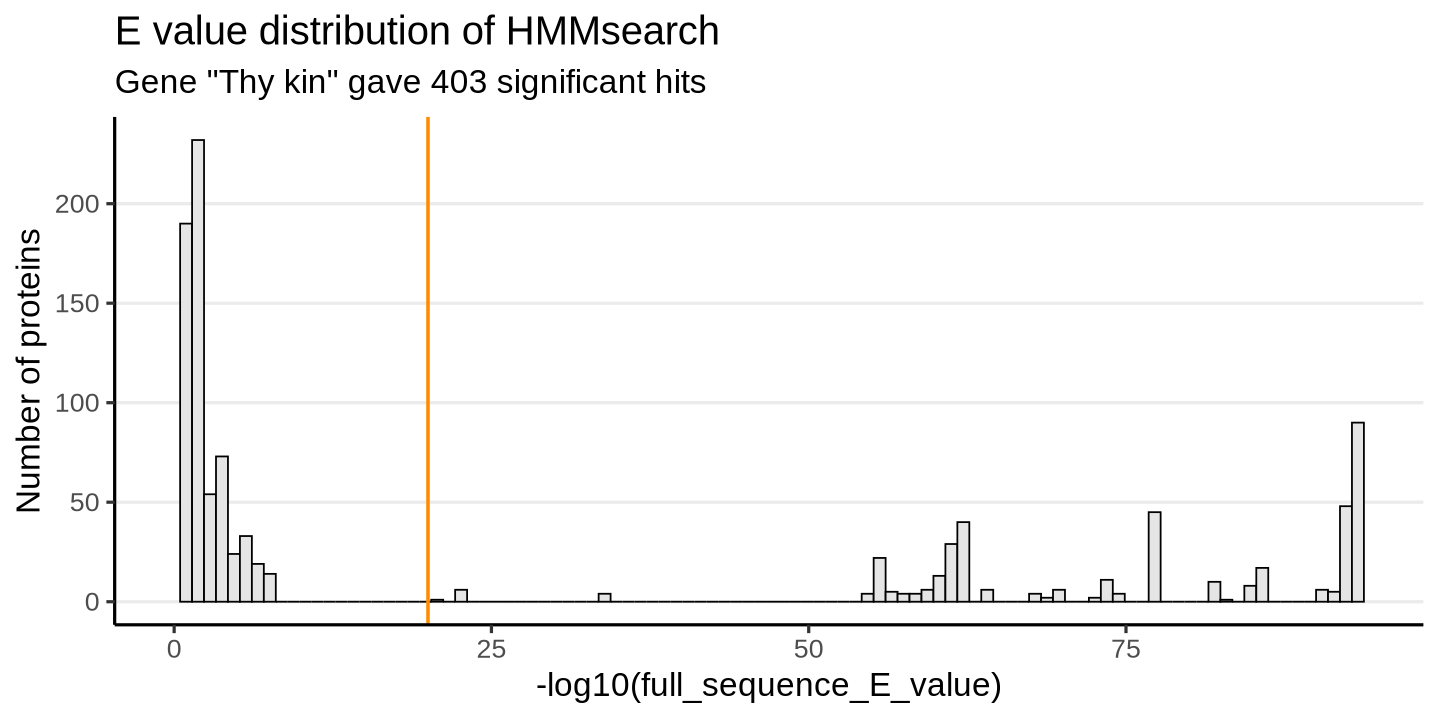

Warning message in dir.create(out_ann):
“'analysis/2025-01-22/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 1941”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed

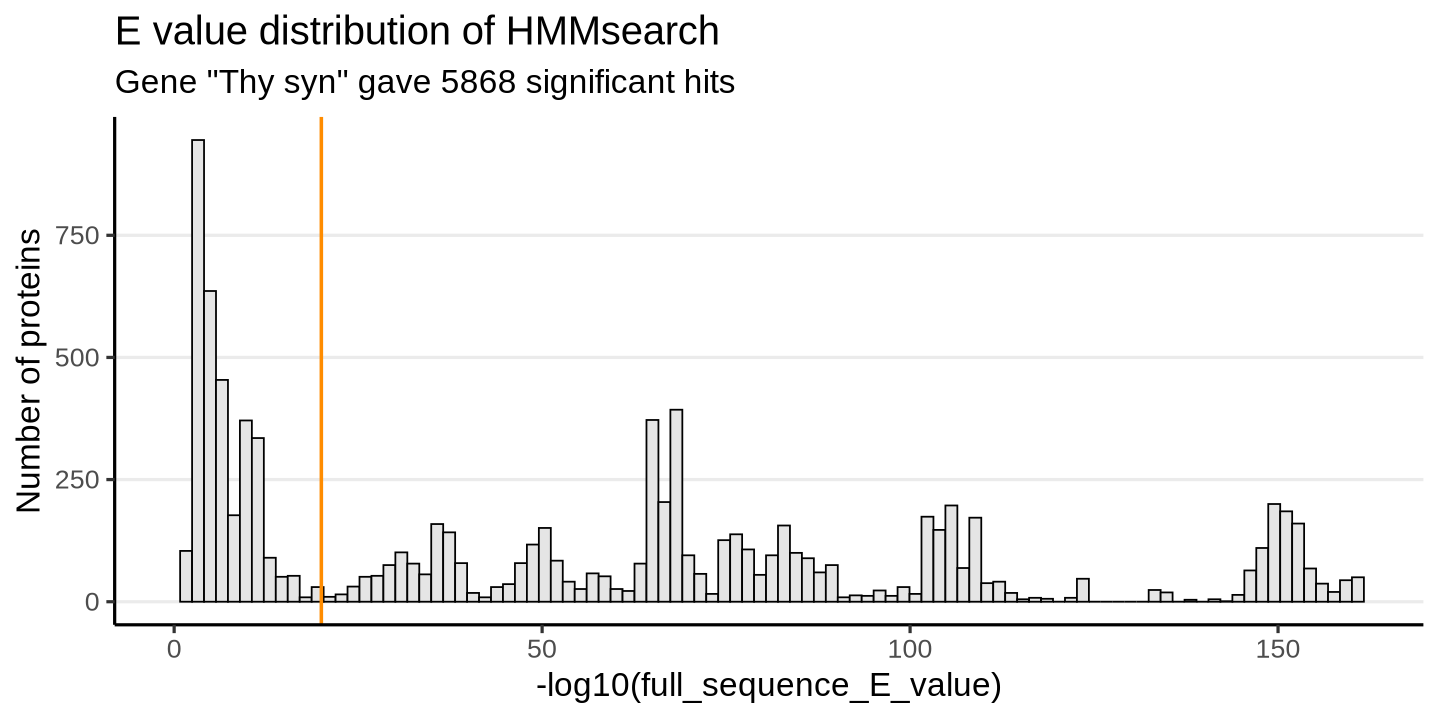

List of 9
 $ Aat         : chr [1:275] "CAH1027064.1:1-373" "CAH1068463.1:1-373" "CAH1068712.1:1-373" "CAH1068712.1:1-373" ...
 $ Ara iso     : chr [1:662] "QZI79977.1:1-133" "WPK34261.1:1-128" "ANN87479.1:1-128" "ANN87479.1:1-128" ...
 $ dCTPase     : chr [1:1818] "AIM50610.1:1-173" "AIM50610.1:1-173" "AKE45257.1:1-173" "AKE45257.1:1-173" ...
 $ HMase       : chr [1:1757] "QGT55273.1:1-232" "QGT55273.1:1-232" "ASD53781.1:1-238" "ASD53781.1:1-238" ...
 $ dNMP kinase : chr [1:1940] "QBP05767.1:1-244" "ANN87645.1:1-244" "ANN87645.1:1-244" "YP_009289136.1:1-244" ...
 $ NTP transfer: chr [1:414] "WPK29073.1:1-561" "XAO15059.1:1-561" "AHV82754.1:1-561" "AHV82754.1:1-561" ...
 $ Thy kin     : chr [1:403] "ANN87484.1:1-182" "ANN87484.1:1-182" "YP_009288975.1:1-182" "AKE45242.1:1-182" ...
 $ Thy syn     : chr [1:5868] "WPK34185.1:1-286" "AWY07767.1:1-286" "AWY07767.1:1-286" "QBP05585.1:1-286" ...
 $ Glu transfer: chr [1:1919] "AFU63986.1:1-358" "AFU63986.1:1-358" "ATN93007.1:1-358" "ATN93007.1

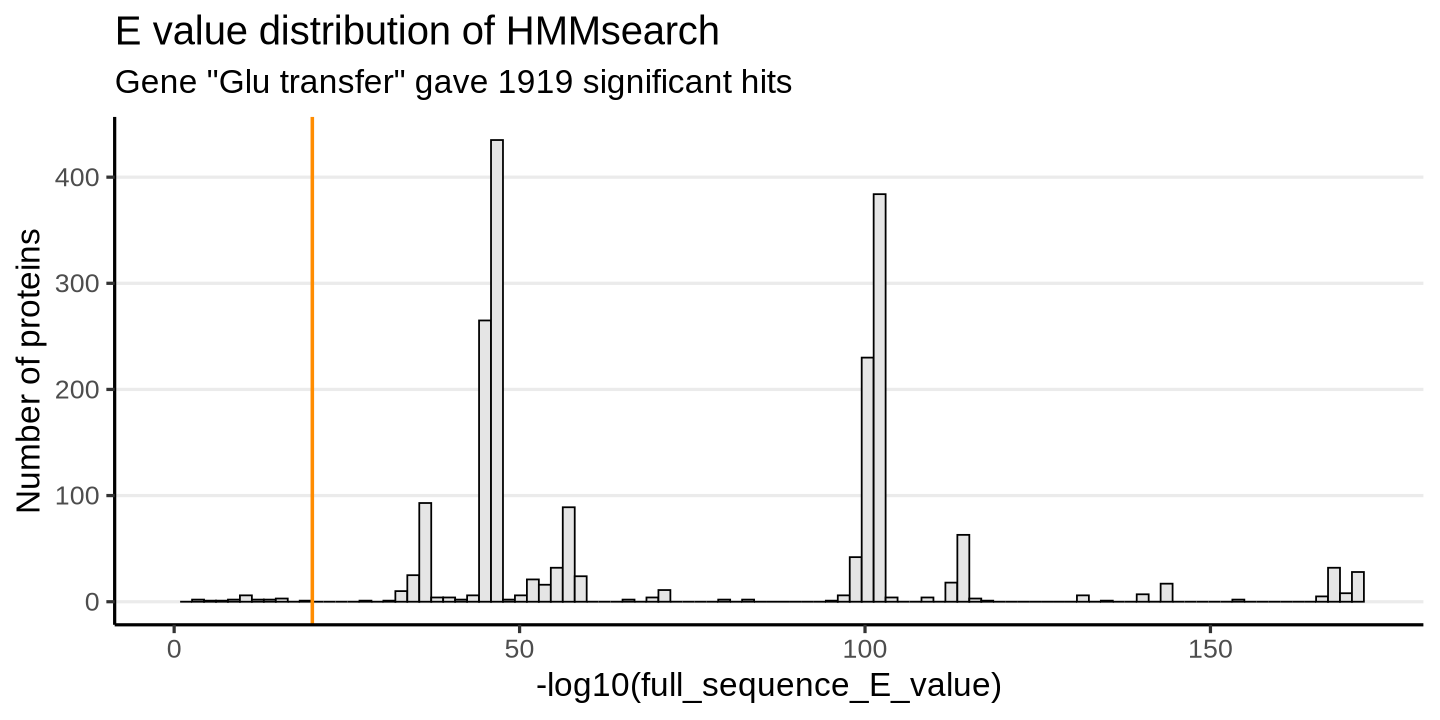

In [53]:
# Annotate genes across genome collections

annotation_genes <- c('Aat','Ara iso','dCTPase','HMase','dNMP kinase','NTP transfer','Thy kin','Thy syn','Glu transfer')
annotation_genes

## Check spelling
all(annotation_genes %in% levels(data$annotation))

## Combine protein fasta
protein_db <- paste0(out_path,'protein.faa')
sys_call <- paste('cat ',fs$validation$protein,fs$test$protein,fs$test2$protein,'>',protein_db)
system(sys_call, intern=TRUE)


## Iterate annotation over genes
result <- list()
for (i in annotation_genes) {
    result[[i]] <- annotate_gene_by_hmm_profile(data, gene = i, search_db = protein_db, dir = out_path, 
                                                e_value_treshold=1e-10)$Sequence
}

## View
str(result, max.level = 2)

In [63]:
## Combine features across collections

## Re-format result
rdf <- data.frame('collection'=character(), 'gene'=character(), 'seq_id'=character())
for (i in names(result)) {
    rdf <- rbind(rdf, data.frame('gene'=i, 'seq_id'=result[[i]]))
}

## View
str(rdf, max.level = 0)

## Add duplicates to result
rdf$duplicated <- duplicated(rdf$seq_id)

## Tabulate
table(rdf$duplicated)

## Filter
#rdf <- rdf[!rdf$duplicated, ]

## Add gene annotations
features$annotation <- 'Other'
index <- na.omit(match(rdf$seq_id, features$Gene.CDS.Protein.FASTA.Sequence.ID))
features$annotation[index] <- rdf$gene

## Summarize
table(features$annotation)

'data.frame':	15056 obs. of  2 variables:



FALSE  TRUE 
 9285  5771 

Warning message in features$annotation[index] <- rdf$gene:
“number of items to replace is not a multiple of replacement length”



         Aat      Ara iso      dCTPase  dNMP kinase Glu transfer        HMase 
         202          438         1134         1203         1117         1111 
NTP transfer        Other      Thy kin      Thy syn 
         265      5759969          262         3487 

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


 num [1:9, 1:3370] 1 0 0 0 0 0 0 0 0 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:9] "Thy syn" "HMase" "dCTPase" "dNMP kinase" ...
  ..$ : chr [1:3370] "AB757800.1" "AB757801.1" "AF320576.1" "AF399011.1" ...



Arabinosylation         Generic   Glucosylation    Thy syn only 
            271             423             584            2092 


    >2 Aat genes 5ara-ara-ara-hdC     5ara-ara-hdC         5ara-hdC 
               2               46              103              120 
         glucose          Unknown 
             584             2515 

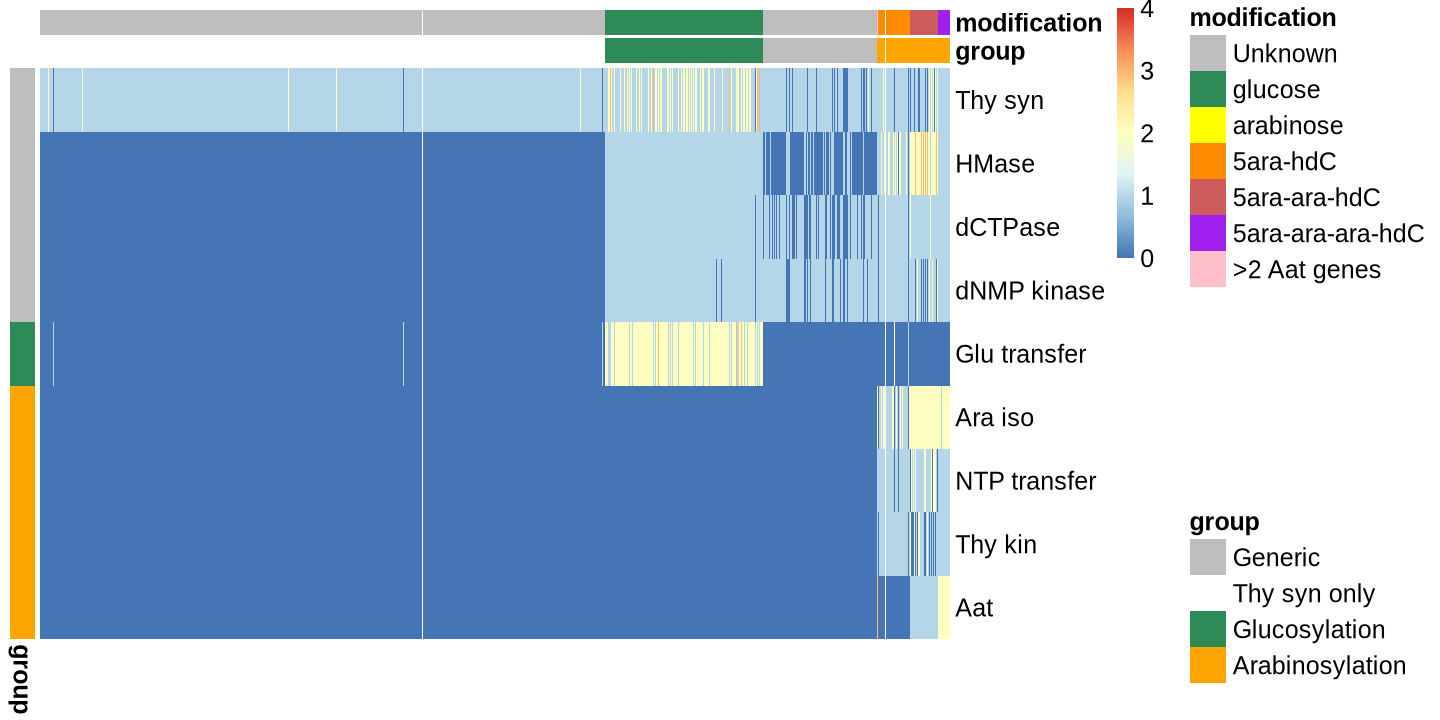

In [279]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=6)
set.seed(42)

## Summarize gene counts
df <- features %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- !df$annotation %in% c('Other','DNA pol')
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()
str(mat)

## Annotations

### Row
rann <- data.frame(
    row.names = rownames(mat),
    group = c('Generic','Generic','Generic','Generic','Glucosylation',
              'Arabinosylation','Arabinosylation','Arabinosylation','Arabinosylation')
)

### Col
cann <- data.frame(
    row.names = colnames(mat)
)

##  Cluster

### Level 1
cann$group <- 'Thy syn only'
cann$group[mat['HMase',] > 0 | mat['dCTPase',] > 0 | mat['dNMP kinase',] > 0] <- 'Generic'
cann$group[cann$group == 'Generic' & mat['Glu transfer',] > 0] <- 'Glucosylation'
cann$group[cann$group == 'Generic' & mat['Ara iso',] > 0 | mat['NTP transfer',] > 0 | mat['Thy kin',] > 0] <- 'Arabinosylation'

### Level 2
cann$modification <- 'Unknown'
cann$modification[cann$group == 'Glucosylation'] <- 'glucose'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==0] <- '5ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==1] <- '5ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==2] <- '5ara-ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',] > 2] <- '>2 Aat genes'

## Order
mat <- mat[,order(cann$group, cann$modification, decreasing = c(TRUE, TRUE), method = 'radix')]

## Plot
p1 <- pheatmap::pheatmap(mat, cluster_rows = FALSE, cluster_cols=FALSE,
                   show_colnames=FALSE, annotation_colors=cols,
                   annotation_row = rann, annotation_col = cann,
                   fontsize = 15)

## Quantify
table(cann$group)
table(cann$modification)

In [226]:
# De-duplication of genome accession numbers
cann[which(cann$modification == '>2 Aat genes'), ]

,group,modification
,<chr>,<chr>
HM004124.1,Arabinosylation,>2 Aat genes
NC_014663.1,Arabinosylation,>2 Aat genes


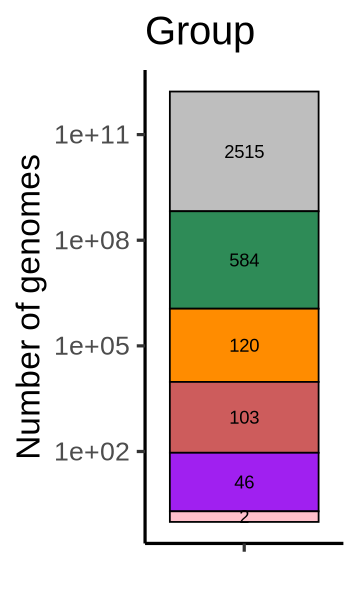

In [284]:
# Visualize groups
options(repr.plot.width=3, repr.plot.height=5)

## Fetch
df <- as.data.frame(table(cann$modification))
names(df) <- c('group','freq')

## Order
df <- df[order(df$freq, decreasing = TRUE), ]
df$group <- factor(df$group, unique(df$group))

## Plot
p2 <- ggplot(df, aes('', freq, fill=group, label=freq)) +
  geom_col(position = 'stack', col='black') +
  geom_text(position = position_stack(vjust = .5)) +
  scale_fill_manual(values = cols$modification) +
  scale_y_continuous(trans='log10') +
  theme_classic(20) +
  guides(
      fill = guide_none()
  ) +
  labs(title='Group',y='Number of genomes',x=NULL,fill='Group')
p2

In [286]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.1.3       bluster_1.16.0      ape_5.8-1          
 [4] msa_1.38.0          Biostrings_2.74.0   GenomeInfoDb_1.42.0
 [7] XVector_0.46.0      IRanges_2.40.0      S4Vectors_0.44.0   
[10] BiocGenerics_0.52.0 gggenes_0.5.1       ggplot2_3.5.1      
